# Load Replay

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [196]:
replay_json = input()
#df = pd.read_json("EUW1-5237530168.rofl.json")
df = pd.read_json(replay_json)
df = df.sort_values(by=["time"])

EUW1-5270795542.rofl.json


In [229]:
champs = pd.DataFrame(pd.concat([df["time"], df["champs"]], axis=1, keys=['time', 'champs']))
champs

time                                             champs
0         2.010997  [{"id": 2624, "name": "varus", "hp": 530.0, "m...
1         2.127793  [{"id": 2624, "name": "varus", "hp": 530.0, "m...
2         2.194533  [{"id": 2624, "name": "varus", "hp": 530.0, "m...
3         2.261273  [{"id": 2624, "name": "varus", "hp": 530.0, "m...
4         2.328013  [{"id": 2624, "name": "varus", "hp": 530.0, "m...
...            ...                                                ...
12032  1230.322632  [{"id": 2624, "name": "varus", "hp": 1408.5250...
12031  1230.322632  [{"id": 2624, "name": "varus", "hp": 1408.5250...
12030  1230.322632  [{"id": 2624, "name": "varus", "hp": 1408.5250...
12040  1230.322632  [{"id": 2624, "name": "varus", "hp": 1408.5250...
12104  1230.322632  [{"id": 2624, "name": "varus", "hp": 1408.5250...

[12105 rows x 2 columns]

# Object Category Analysis

In [198]:
champs.columns

Index(['time', 'champs'], dtype='object')

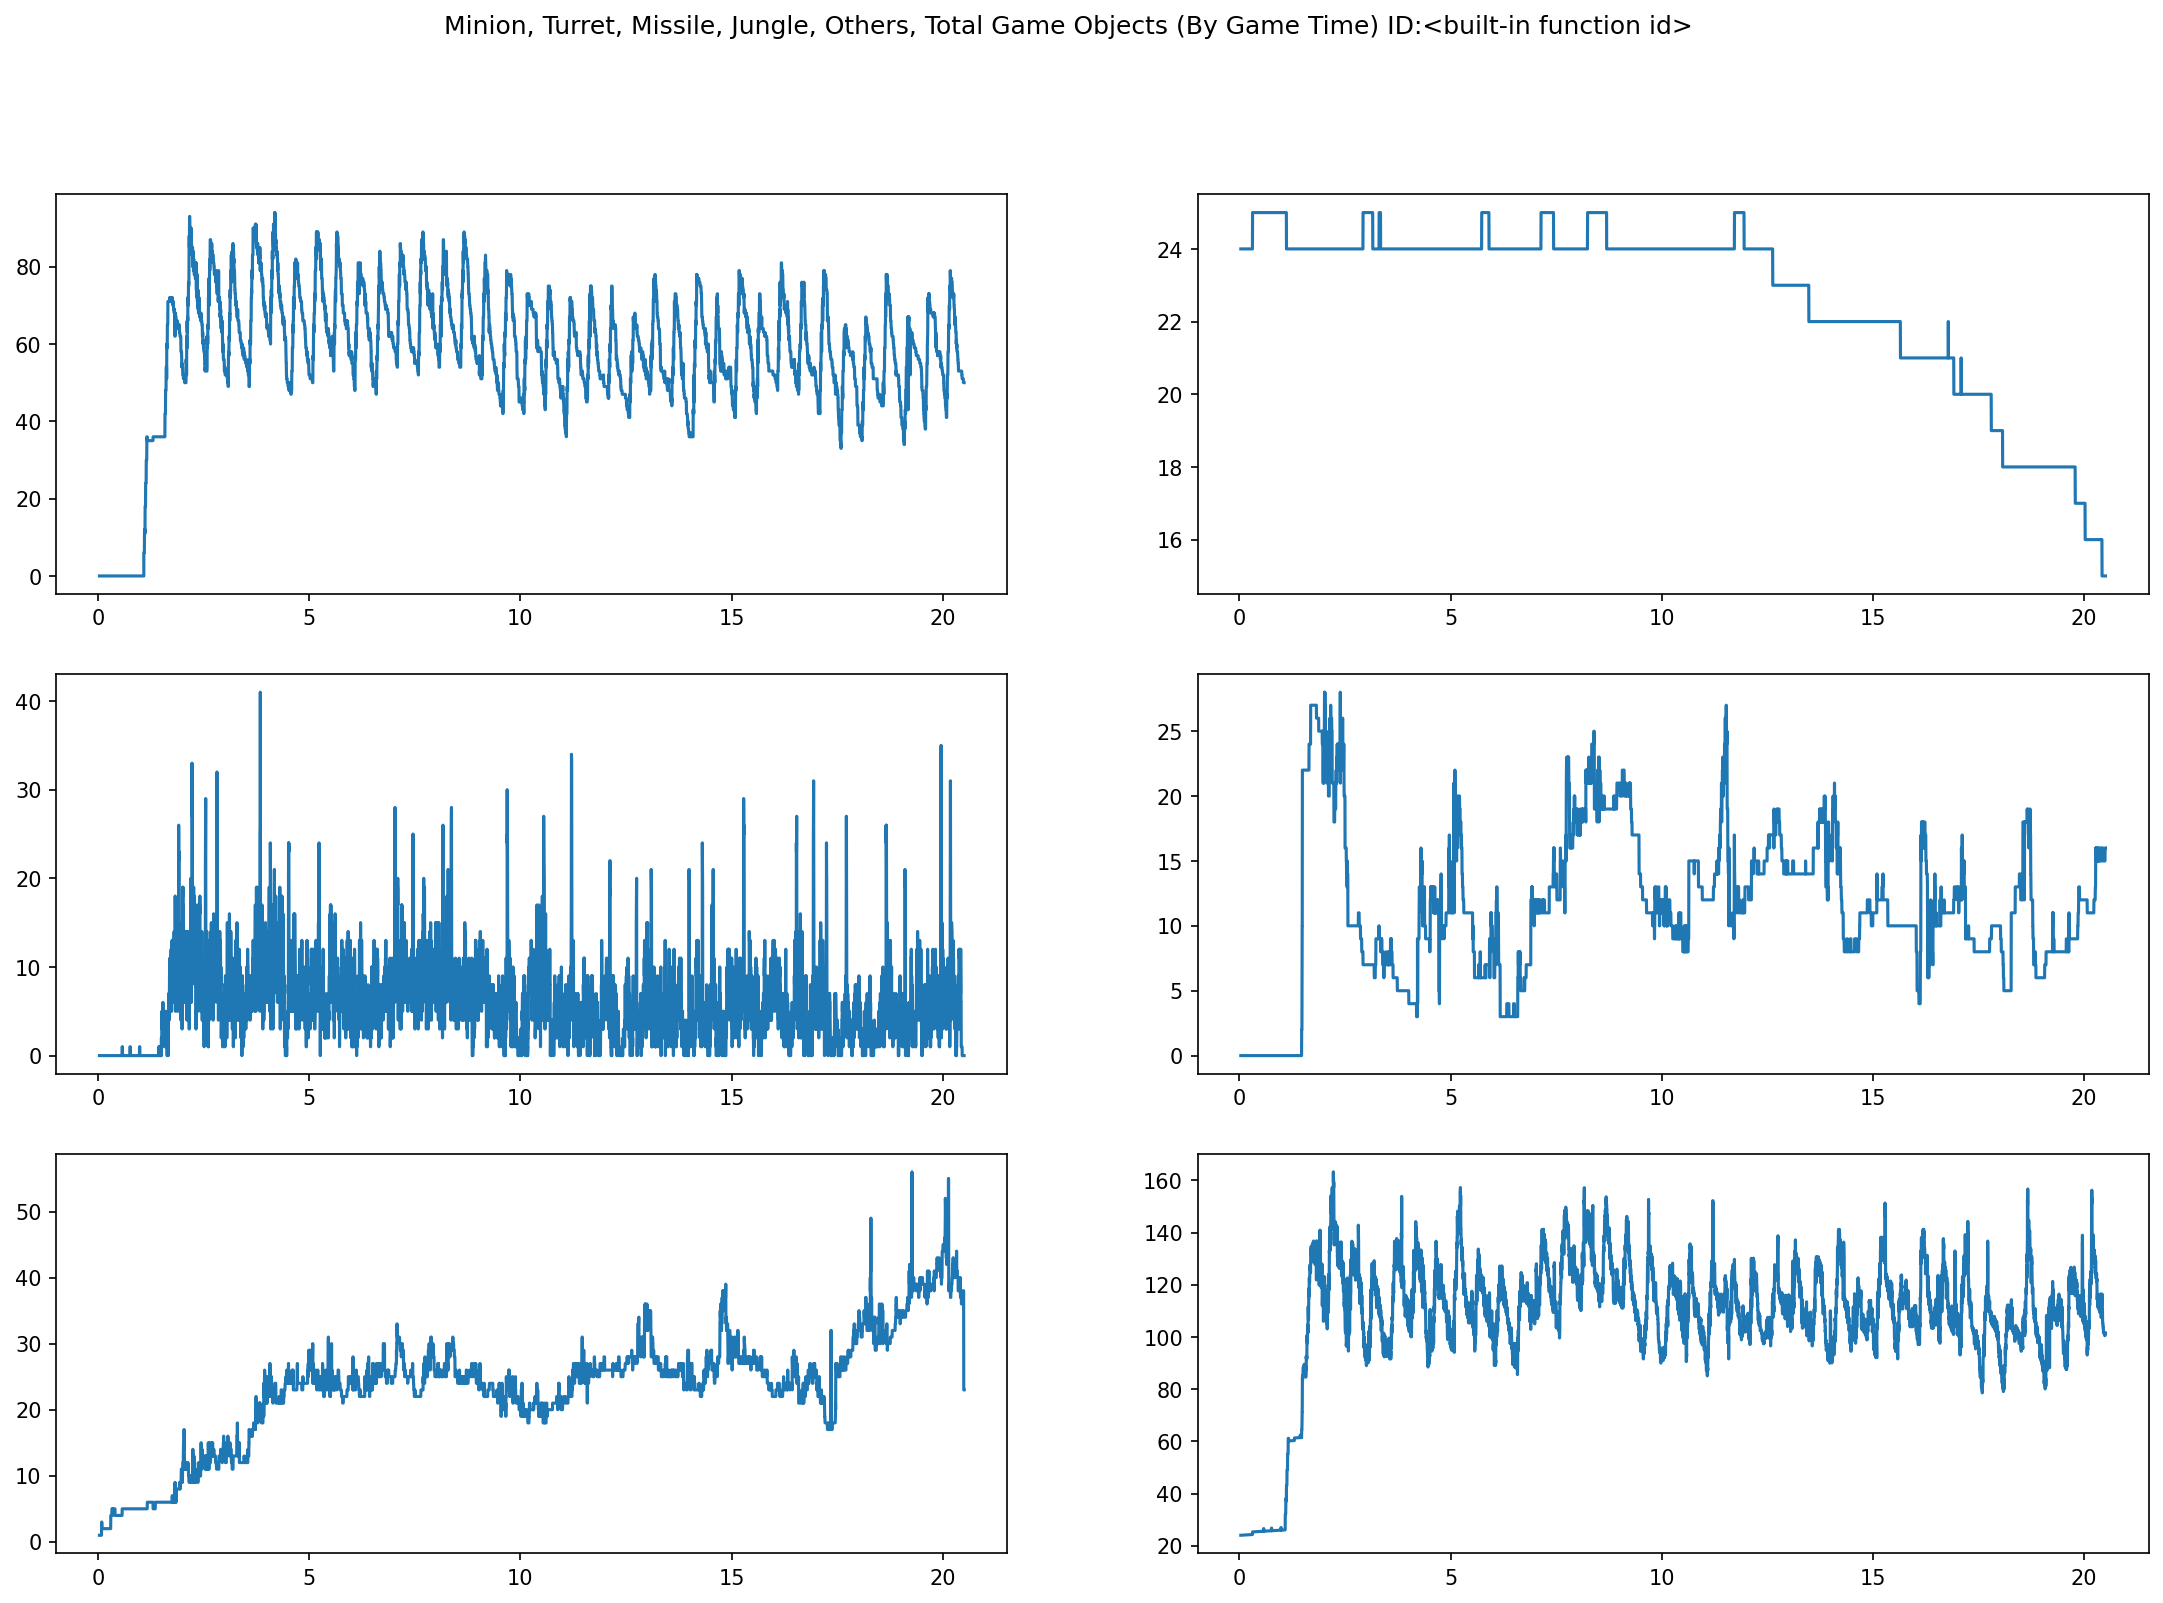

In [199]:
# Data
cur = df[(df["time"] > 60*0) & (df["time"] < 60*35)]
cur["time_mins"]     = cur["time"].apply(lambda x: x / 60)
cur["minion_count"]  = cur["minions"].apply(lambda x: len(x))
cur["turret_count"]  = cur["turrets"].apply(lambda x: len(x))
cur["jungle_count"]  = cur["jungle"].apply(lambda x: len(x))
cur["missile_count"] = cur["missiles"].apply(lambda x: len(x))
cur["others_count"]  = cur["others"].apply(lambda x: len(x))
cur["total_count"]   = cur.iloc[:, -6:-1].sum(axis=1)

# Set Plot Size
plt.rcParams["figure.figsize"] = (6*3, 6*2)

# Plotting
fig = plt.figure()
fig.suptitle( \
    'Minion, Turret, Missile, Jungle, Others, Total Game Objects (By Game Time) ID:{}' \
    .format(id))

plt.subplot(3, 2, 1)
plt.plot(cur["time_mins"], cur["minion_count"])

plt.subplot(3, 2, 2)
plt.plot(cur["time_mins"], cur["turret_count"])

plt.subplot(3, 2, 3)
plt.plot(cur["time_mins"], cur["missile_count"])

plt.subplot(3, 2, 4)
plt.plot(cur["time_mins"], cur["jungle_count"])

plt.subplot(3, 2, 5)
plt.plot(cur["time_mins"], cur["others_count"])

plt.subplot(3, 2, 6)
plt.plot(cur["time_mins"], cur["total_count"])

## Construct Champion Objects

In [239]:
PREV_POS_STEP_DELAY = 8 # (1 = prev, 8 = -1 sec, 80 = -10 sec, 480 -60 sec)
champs_corrected = {}

#print(champs)

# Correct the Champions (They're not guarenteed to be in order)
for i in range(10):
  cur_times  = pd.DataFrame(champs["time"])
  cur_champs = champs["champs"].apply(lambda x: x[i])

  cur_champs = pd.read_json("\n".join(cur_champs.tolist()), lines=True)
  cur_champs = cur_times.join(cur_champs)

  names = pd.unique(cur_champs["name"])
  for n in names:
    if not n in champs_corrected:
      champs_corrected[n] = pd.DataFrame()
    champs_corrected[n] = \
      pd.DataFrame.append(champs_corrected[n], cur_champs[cur_champs["name"] == n])
  #print(pd.unique(cur_champs["name"]))

# Sort the champs
for i, n in enumerate(champs_corrected):
  print('champ at:', i, n)

  # Sort by time
  champs_corrected[n] = champs_corrected[n].sort_values(by=["time"])

  # Set prev position to lagged version of current position
  champs_corrected[n] = champs_corrected[n].drop(columns=[
      "prev_pos_x",
      "prev_pos_y",
      "prev_pos_z"
  ])
  champs_corrected[n]["prev_pos_x"] = champs_corrected[n]["pos_x"]
  champs_corrected[n]["prev_pos_y"] = champs_corrected[n]["pos_y"]
  champs_corrected[n]["prev_pos_z"] = champs_corrected[n]["pos_z"]
  #if i == 0: print(champs_corrected[n][["pos_x", "pos_z", "prev_pos_x", "prev_pos_z"]][480:560])
  champs_corrected[n]["prev_pos_x"] = champs_corrected[n]["prev_pos_x"].shift(-PREV_POS_STEP_DELAY)
  champs_corrected[n]["prev_pos_y"] = champs_corrected[n]["prev_pos_y"].shift(-PREV_POS_STEP_DELAY)
  champs_corrected[n]["prev_pos_z"] = champs_corrected[n]["prev_pos_z"].shift(-PREV_POS_STEP_DELAY)
  #if i == 0: print(champs_corrected[n][["pos_x", "pos_z", "prev_pos_x", "prev_pos_z"]][480:560])
    
  # Extract spell information
  spells = ["q", "w", "e", "r", "d", "f"]
  for spell in spells:
    cur_champ = champs_corrected[n]
    cur_spell = cur_champ[spell]
    #print('cur_spell:', cur_spell)
    cur_spell = pd.read_json("\n".join(cur_spell.tolist()), lines=True)
    cur_spell = cur_spell.add_prefix(f"{spell}_")
    champs_corrected[n] = champs_corrected[n].join(cur_spell)
  
  # Append prev spell cds to easily calculate spell usage times
  for spell in spells:
    cur_champ = champs_corrected[n]
    cur_champ[f"{spell}_prev_cd"] = cur_champ[f"{spell}_cd"]
    cur_champ[f"{spell}_prev_cd"] = cur_champ[f"{spell}_prev_cd"].shift(-1)
  
  # Every time current spell cd goes from a number to 0, that is a spell cast
  def get_champ_spell_casts(row):
    return row[f"{spell}_cd"] == 0 and row[f"{spell}_cd"] < row[f"{spell}_prev_cd"]
    
  for spell in spells:
    cur_champ = champs_corrected[n]
    #cur_champ[f"{spell}_cast"] = cur_champ.apply(lambda row: get_champ_spell_casts(row), axis=1)
    cur_champ[f"{spell}_cast"] = cur_champ.apply(get_champ_spell_casts, 1)

champ at: 0 varus
champ at: 1 jayce
champ at: 2 hecarim
champ at: 3 ornn
champ at: 4 darius
champ at: 5 lux
champ at: 6 twistedfate
champ at: 7 zilean
champ at: 8 udyr
champ at: 9 jinx


In [240]:
champs_corrected["varus"].columns

Index(['time', 'id', 'name', 'hp', 'maxHp', 'ad', 'armor', 'mr', 'movSpd',
       'alive', 'pos_x', 'pos_y', 'pos_z', 'visible', 'lastVisible', 'crit',
       'critMulti', 'ap', 'atkSpdMulti', 'team', 'q', 'w', 'e', 'r', 'd', 'f',
       'items', 'level', 'xp', 'mana', 'maxMana', 'prev_pos_x', 'prev_pos_y',
       'prev_pos_z', 'q_ability_name', 'q_cd', 'q_level', 'w_ability_name',
       'w_cd', 'w_level', 'e_ability_name', 'e_cd', 'e_level',
       'r_ability_name', 'r_cd', 'r_level', 'd_ability_name', 'd_cd',
       'd_level', 'f_ability_name', 'f_cd', 'f_level', 'q_prev_cd',
       'w_prev_cd', 'e_prev_cd', 'r_prev_cd', 'd_prev_cd', 'f_prev_cd',
       'q_cast', 'w_cast', 'e_cast', 'r_cast', 'd_cast', 'f_cast'],
      dtype='object')

In [225]:
champs_corrected["varus"].iloc[8 * 60 * 2]

time                                                      48.314674
id                                                             2624
name                                                          varus
hp                                                            610.0
maxHp                                                         610.0
ad                                                             74.4
armor                                                          33.0
mr                                                             30.0
movSpd                                                        330.0
alive                                                          True
pos_x                                                  10320.146484
pos_y                                                     49.034336
pos_z                                                   3266.871094
visible                                                        True
lastVisible                                     

### Count Spell Casts

In [246]:
for c in champs_corrected:
    print(c)
    print(champs_corrected[c].r_cast.value_counts())

varus
False    12604
True         5
Name: r_cast, dtype: int64
jayce
False    12265
True       136
Name: r_cast, dtype: int64
hecarim
False    11069
True         5
Name: r_cast, dtype: int64
ornn
False    12095
True        10
Name: r_cast, dtype: int64
darius
False    11071
True         3
Name: r_cast, dtype: int64
lux
False    13444
True         8
Name: r_cast, dtype: int64
twistedfate
False    10519
True         6
Name: r_cast, dtype: int64
zilean
False    12100
True         5
Name: r_cast, dtype: int64
udyr
False    11903
True       202
Name: r_cast, dtype: int64
jinx
False    13597
True         3
Name: r_cast, dtype: int64


In [241]:
champ_names_for_game = champs_corrected.keys()
print(champ_names_for_game)
champs_corrected["varus"].info()

dict_keys(['varus', 'jayce', 'hecarim', 'ornn', 'darius', 'lux', 'twistedfate', 'zilean', 'udyr', 'jinx'])
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12609 entries, 0 to 12104
Data columns (total 64 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            12609 non-null  float64
 1   id              12609 non-null  int64  
 2   name            12609 non-null  object 
 3   hp              12609 non-null  float64
 4   maxHp           12609 non-null  float64
 5   ad              12609 non-null  float64
 6   armor           12609 non-null  float64
 7   mr              12609 non-null  float64
 8   movSpd          12609 non-null  float64
 9   alive           12609 non-null  bool   
 10  pos_x           12609 non-null  float64
 11  pos_y           12609 non-null  float64
 12  pos_z           12609 non-null  float64
 13  visible         12609 non-null  bool   
 14  lastVisible     12609 non-null  float64
 15  crit          

In [176]:
champs_corrected["varus"].q

0        {"ability_name": "varusq", "cd": 0.0, "level": 0}
0        {"ability_name": "varusq", "cd": 0.0, "level": 0}
1        {"ability_name": "varusq", "cd": 0.0, "level": 0}
1        {"ability_name": "varusq", "cd": 0.0, "level": 0}
2        {"ability_name": "varusq", "cd": 0.0, "level": 0}
                               ...                        
12099    {"ability_name": "varusq", "cd": 0.0, "level": 5}
12100    {"ability_name": "varusq", "cd": 0.0, "level": 5}
12101    {"ability_name": "varusq", "cd": 0.0, "level": 5}
12092    {"ability_name": "varusq", "cd": 0.0, "level": 5}
12012    {"ability_name": "varusq", "cd": 0.0, "level": 5}
Name: q, Length: 12609, dtype: object

In [70]:
champs_corrected["varus"][["pos_x", "pos_z", "prev_pos_x", "prev_pos_z"]][500:600]

pos_x        pos_z   prev_pos_x   prev_pos_z
259  3801.565430  1073.609741  3801.565430  1073.609741
260  3833.977295  1107.302490  3833.977295  1107.302490
261  3865.548340  1140.252686  3865.548340  1140.252686
262  3897.111816  1173.209961  3897.111816  1173.209961
263  3928.670410  1206.171875  3928.670410  1206.171875
..           ...          ...          ...          ...
354  7860.826660  1705.803711  7860.826660  1705.803711
355  7914.346680  1707.725098  7914.346680  1707.725098
356  7931.396973  1732.058350  7931.396973  1732.058350
357  7949.550293  1773.524536  7949.550293  1773.524536
358  7975.547363  1810.987061  7975.547363  1810.987061

[100 rows x 4 columns]

## Construct Missile Objects

In [297]:
missiles = pd.DataFrame(pd.concat([df["time"], df["missiles"]], axis=1, keys=['time', 'missiles']))
missiles[500:600]

time missiles
500  35.000069       []
501  35.068275       []
502  35.135014       []
503  35.185070       []
504  35.251808       []
..         ...      ...
595  40.805157       []
596  40.871895       []
597  40.921951       []
598  40.988689       []
599  41.055428       []

[100 rows x 2 columns]

# 2D-Map Analysis

champ name list: dict_keys(['varus', 'jayce', 'hecarim', 'ornn', 'darius', 'lux', 'twistedfate', 'zilean', 'udyr', 'jinx'])


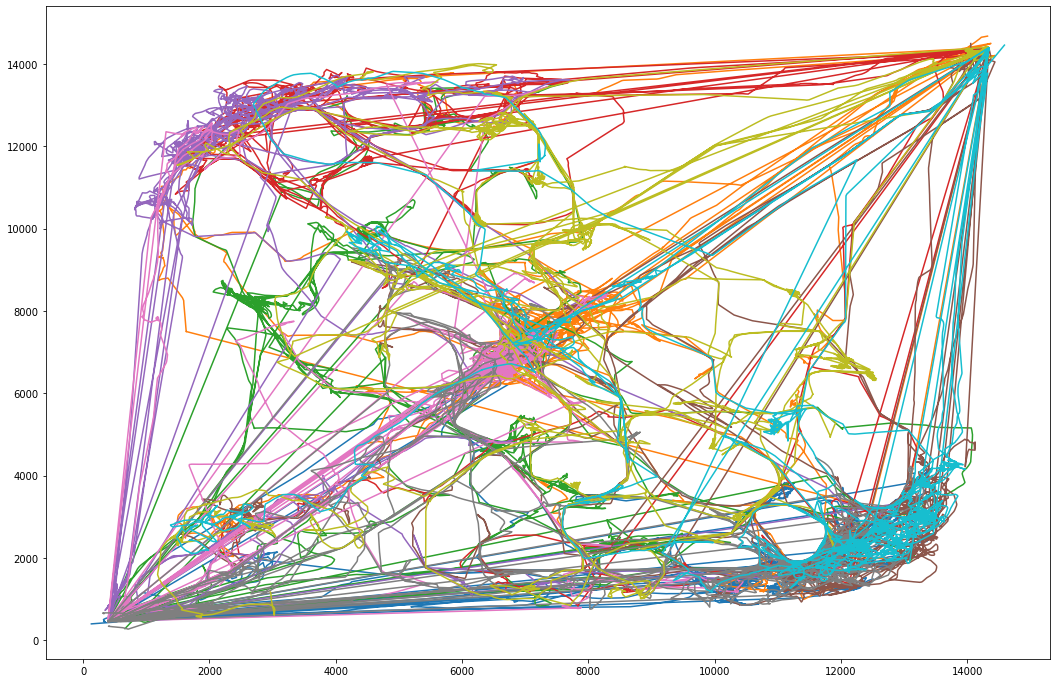

In [9]:
def plot_map(champ_list):
    #champ_names_for_game = champs_corrected.keys()
    print('champ name list:', champ_list)

    """
    for c in champs_corrected:
      plt.plot(champs_corrected[c].pos_x, champs_corrected[c].pos_z)
    """

    # remove (0, 0) rows from a champ

    cs = list(champ_list)
    #cs = ["kindred"]
    for c in cs:
        #new_c = champs_corrected[c][champs_corrected[c].pos_x > 0]
        #new_c = champs_corrected[c][champs_corrected[c].pos_y > 0]
        #plt.plot(new_c.pos_x, new_c.pos_z)
        plt.plot(champs_corrected[c].pos_x, champs_corrected[c].pos_z)
champ_names = champs_corrected.keys()
plot_map(champ_names)

# Split Champ Positions into Global Intent Regions

## Calculate Global Intent Region Parameters

In [10]:
global_region_mult = 2
map_dim  = 16_000
map_width = map_height = map_dim
map_n = int(map_dim / 1000) * global_region_mult
global_intent_region_size = int(map_dim / map_n)
print("Map Region Count, Map Region Size:", map_n, (global_intent_region_size, global_intent_region_size))

Map Region Count, Map Region Size: 32 (500, 500)


## View Global Intent Regions as Line Graph

champ name list: dict_keys(['varus', 'jayce', 'hecarim', 'ornn', 'darius', 'lux', 'twistedfate', 'zilean', 'udyr', 'jinx'])


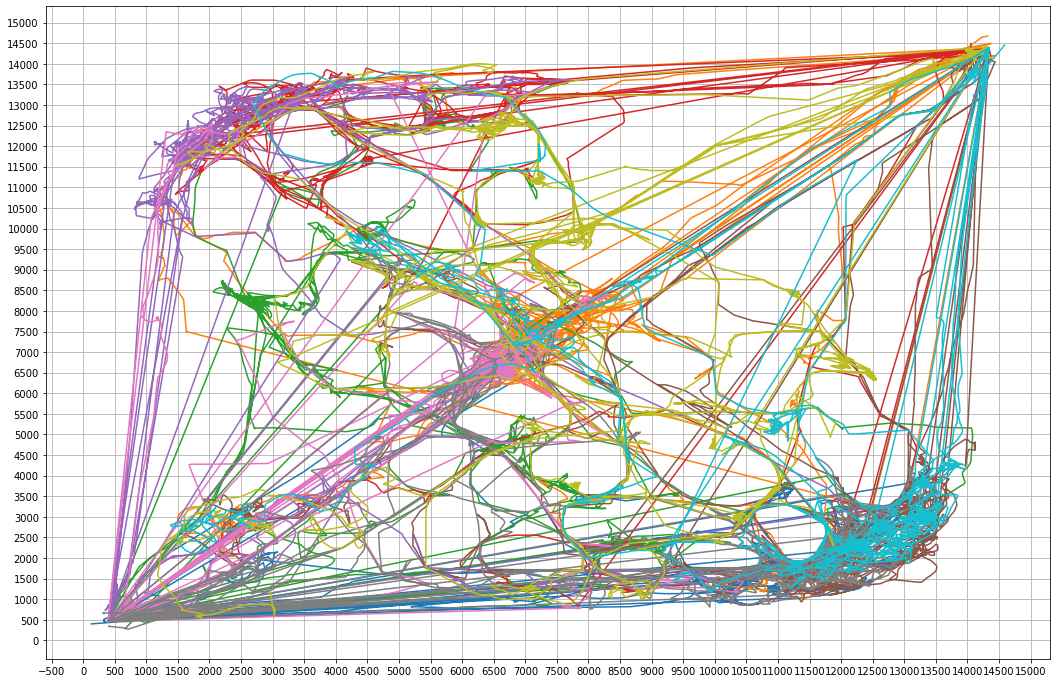

In [11]:
import matplotlib.ticker as plticker

# plot map again with global intent regions
def plot_map_global(champ_list, intervals):
    #champ_names_for_game = champs_corrected.keys()
    print('champ name list:', champ_list)
    
    fig, ax = plt.subplots()
    
    intervals = intervals
    loc = plticker.MultipleLocator(base=intervals)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    
    """
    for c in champs_corrected:
      plt.plot(champs_corrected[c].pos_x, champs_corrected[c].pos_z)
    """

    # remove (0, 0) rows from a champ

    cs = list(champ_list)
    #cs = ["kindred"]
    for c in cs:
        #new_c = champs_corrected[c][champs_corrected[c].pos_x > 0]
        #new_c = champs_corrected[c][champs_corrected[c].pos_y > 0]
        #plt.plot(new_c.pos_x, new_c.pos_z)
        ax.plot(champs_corrected[c].pos_x, champs_corrected[c].pos_z)
    
champ_names = champs_corrected.keys()
plot_map_global(champ_names, global_intent_region_size)

## View Global Intent Regions as Scatter Plot

champ name list: dict_keys(['varus', 'jayce', 'hecarim', 'ornn', 'darius', 'lux', 'twistedfate', 'zilean', 'udyr', 'jinx'])


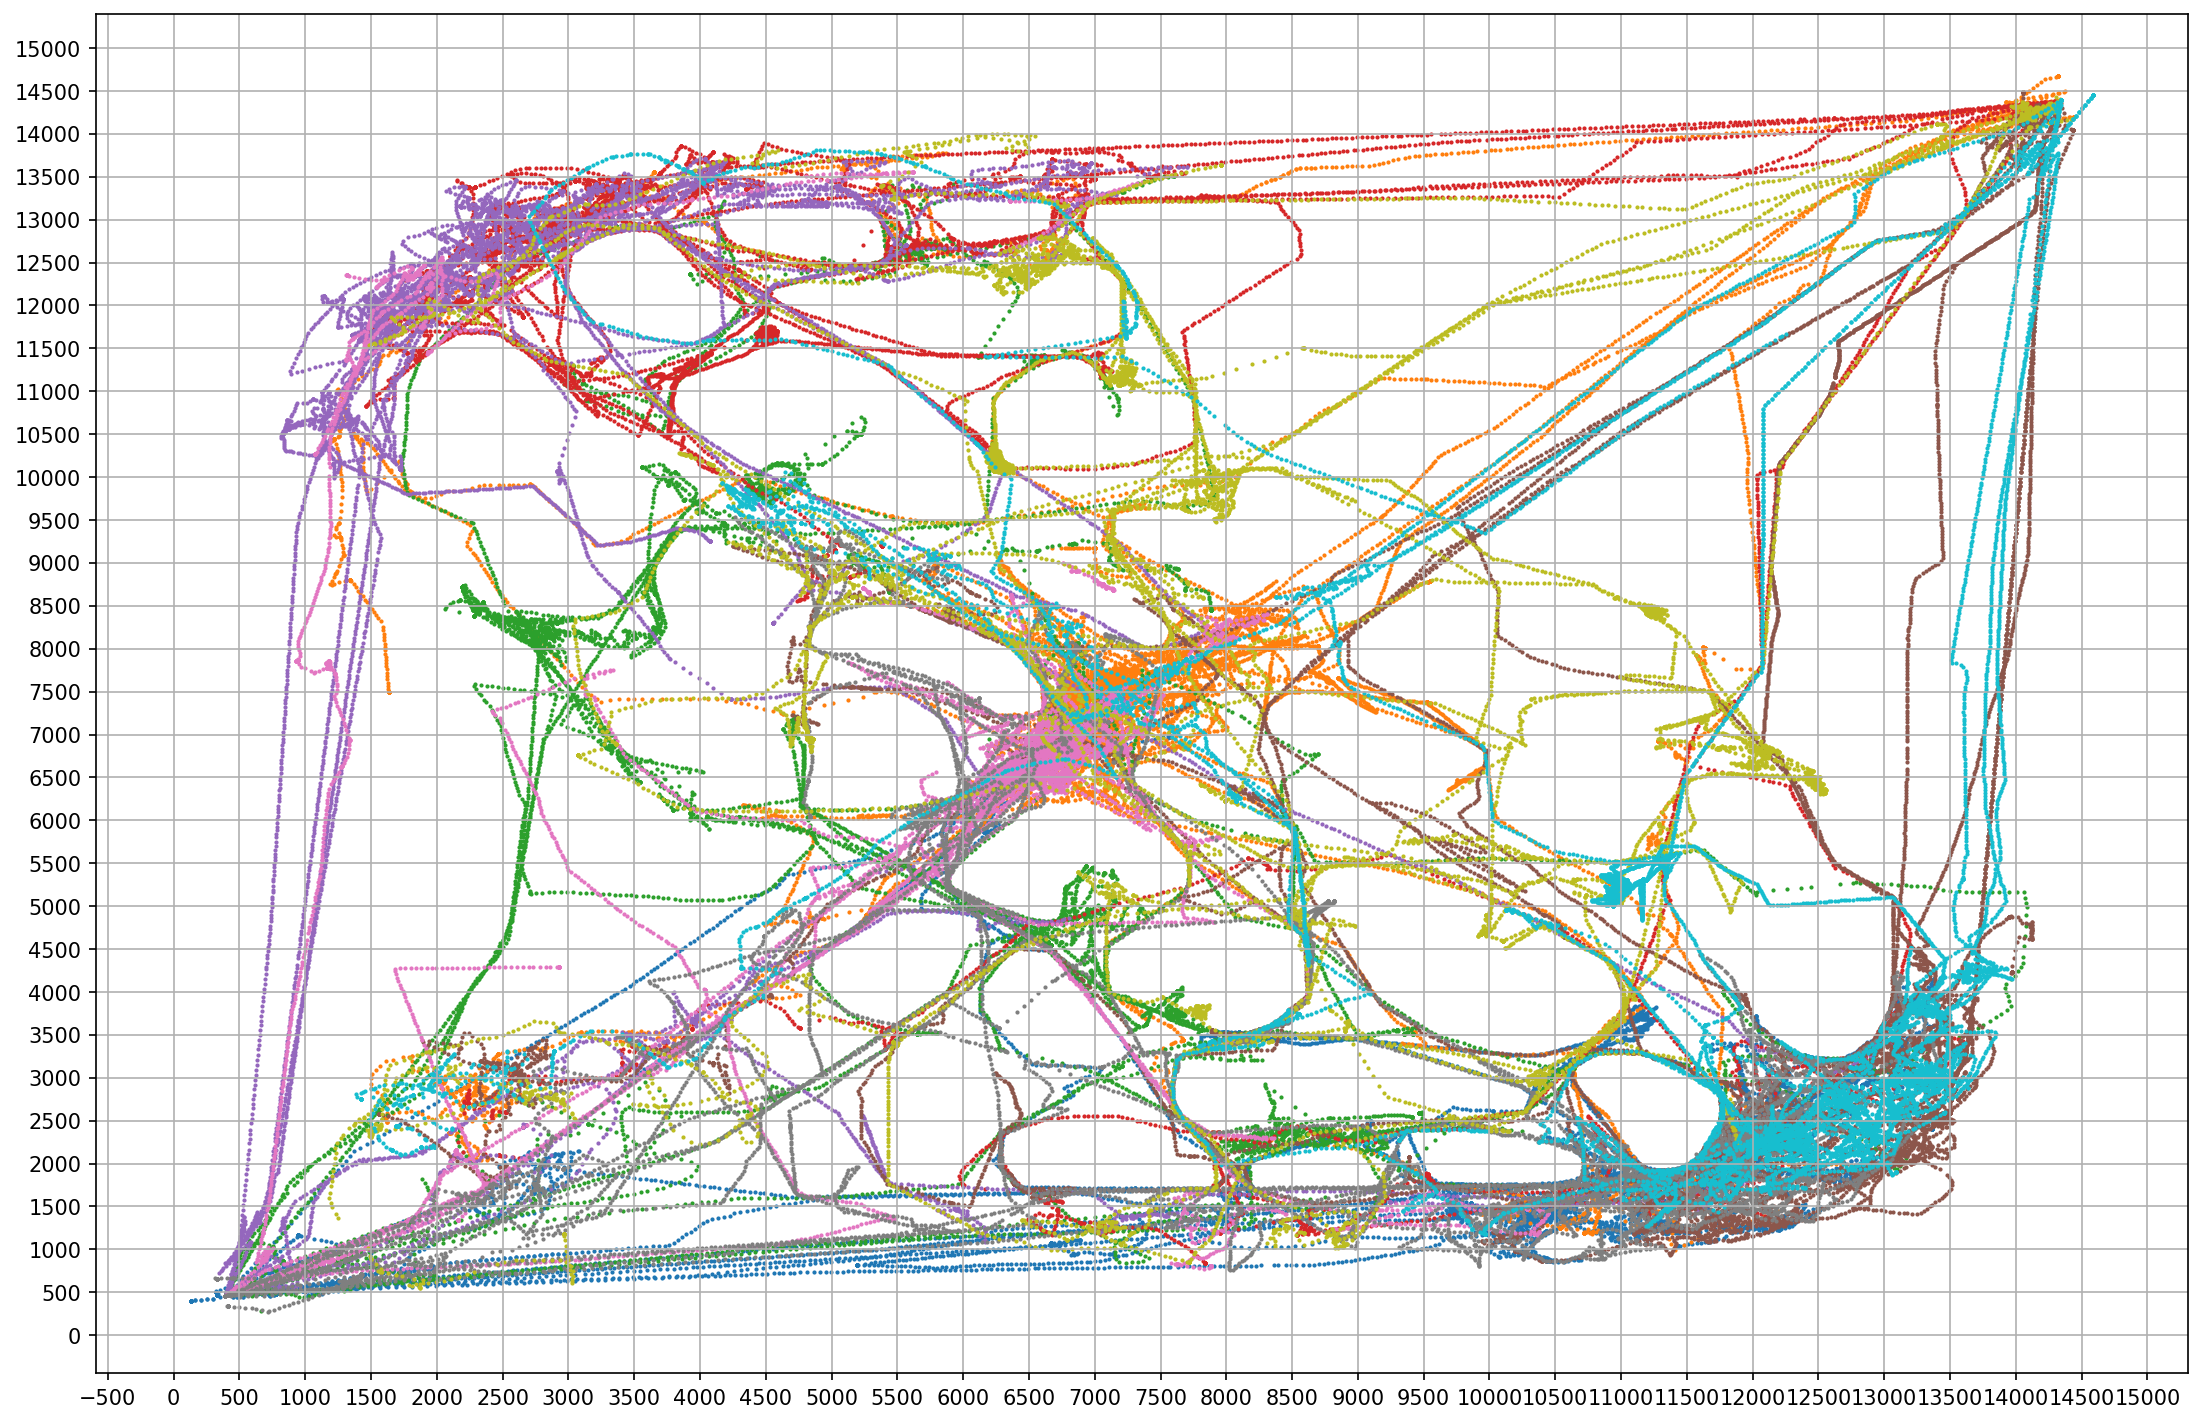

In [91]:
def plot_map_global_scatter(champ_list, intervals):
    #champ_names_for_game = champs_corrected.keys()
    print('champ name list:', champ_list)
    
    fig, ax = plt.subplots()
    
    intervals = intervals
    loc = plticker.MultipleLocator(base=intervals)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    
    """
    for c in champs_corrected:
      plt.plot(champs_corrected[c].pos_x, champs_corrected[c].pos_z)
    """

    # remove (0, 0) rows from a champ

    cs = list(champ_list)
    #cs = ["kindred"]
    for c in cs:
        #new_c = champs_corrected[c][champs_corrected[c].pos_x > 0]
        #new_c = champs_corrected[c][champs_corrected[c].pos_y > 0]
        #plt.plot(new_c.pos_x, new_c.pos_z)
        # ax.plot(champs_corrected[c].pos_x, champs_corrected[c].pos_z)
        ax.scatter(champs_corrected[c].pos_x, champs_corrected[c].pos_z, s=1)
    
champ_names = champs_corrected.keys()
plot_map_global_scatter(champ_names, global_intent_region_size)

## View Global Intent Transitions as Quivers on Global Intent Matrix

champ name list: dict_keys(['varus', 'jayce', 'hecarim', 'ornn', 'darius', 'lux', 'twistedfate', 'zilean', 'udyr', 'jinx'])


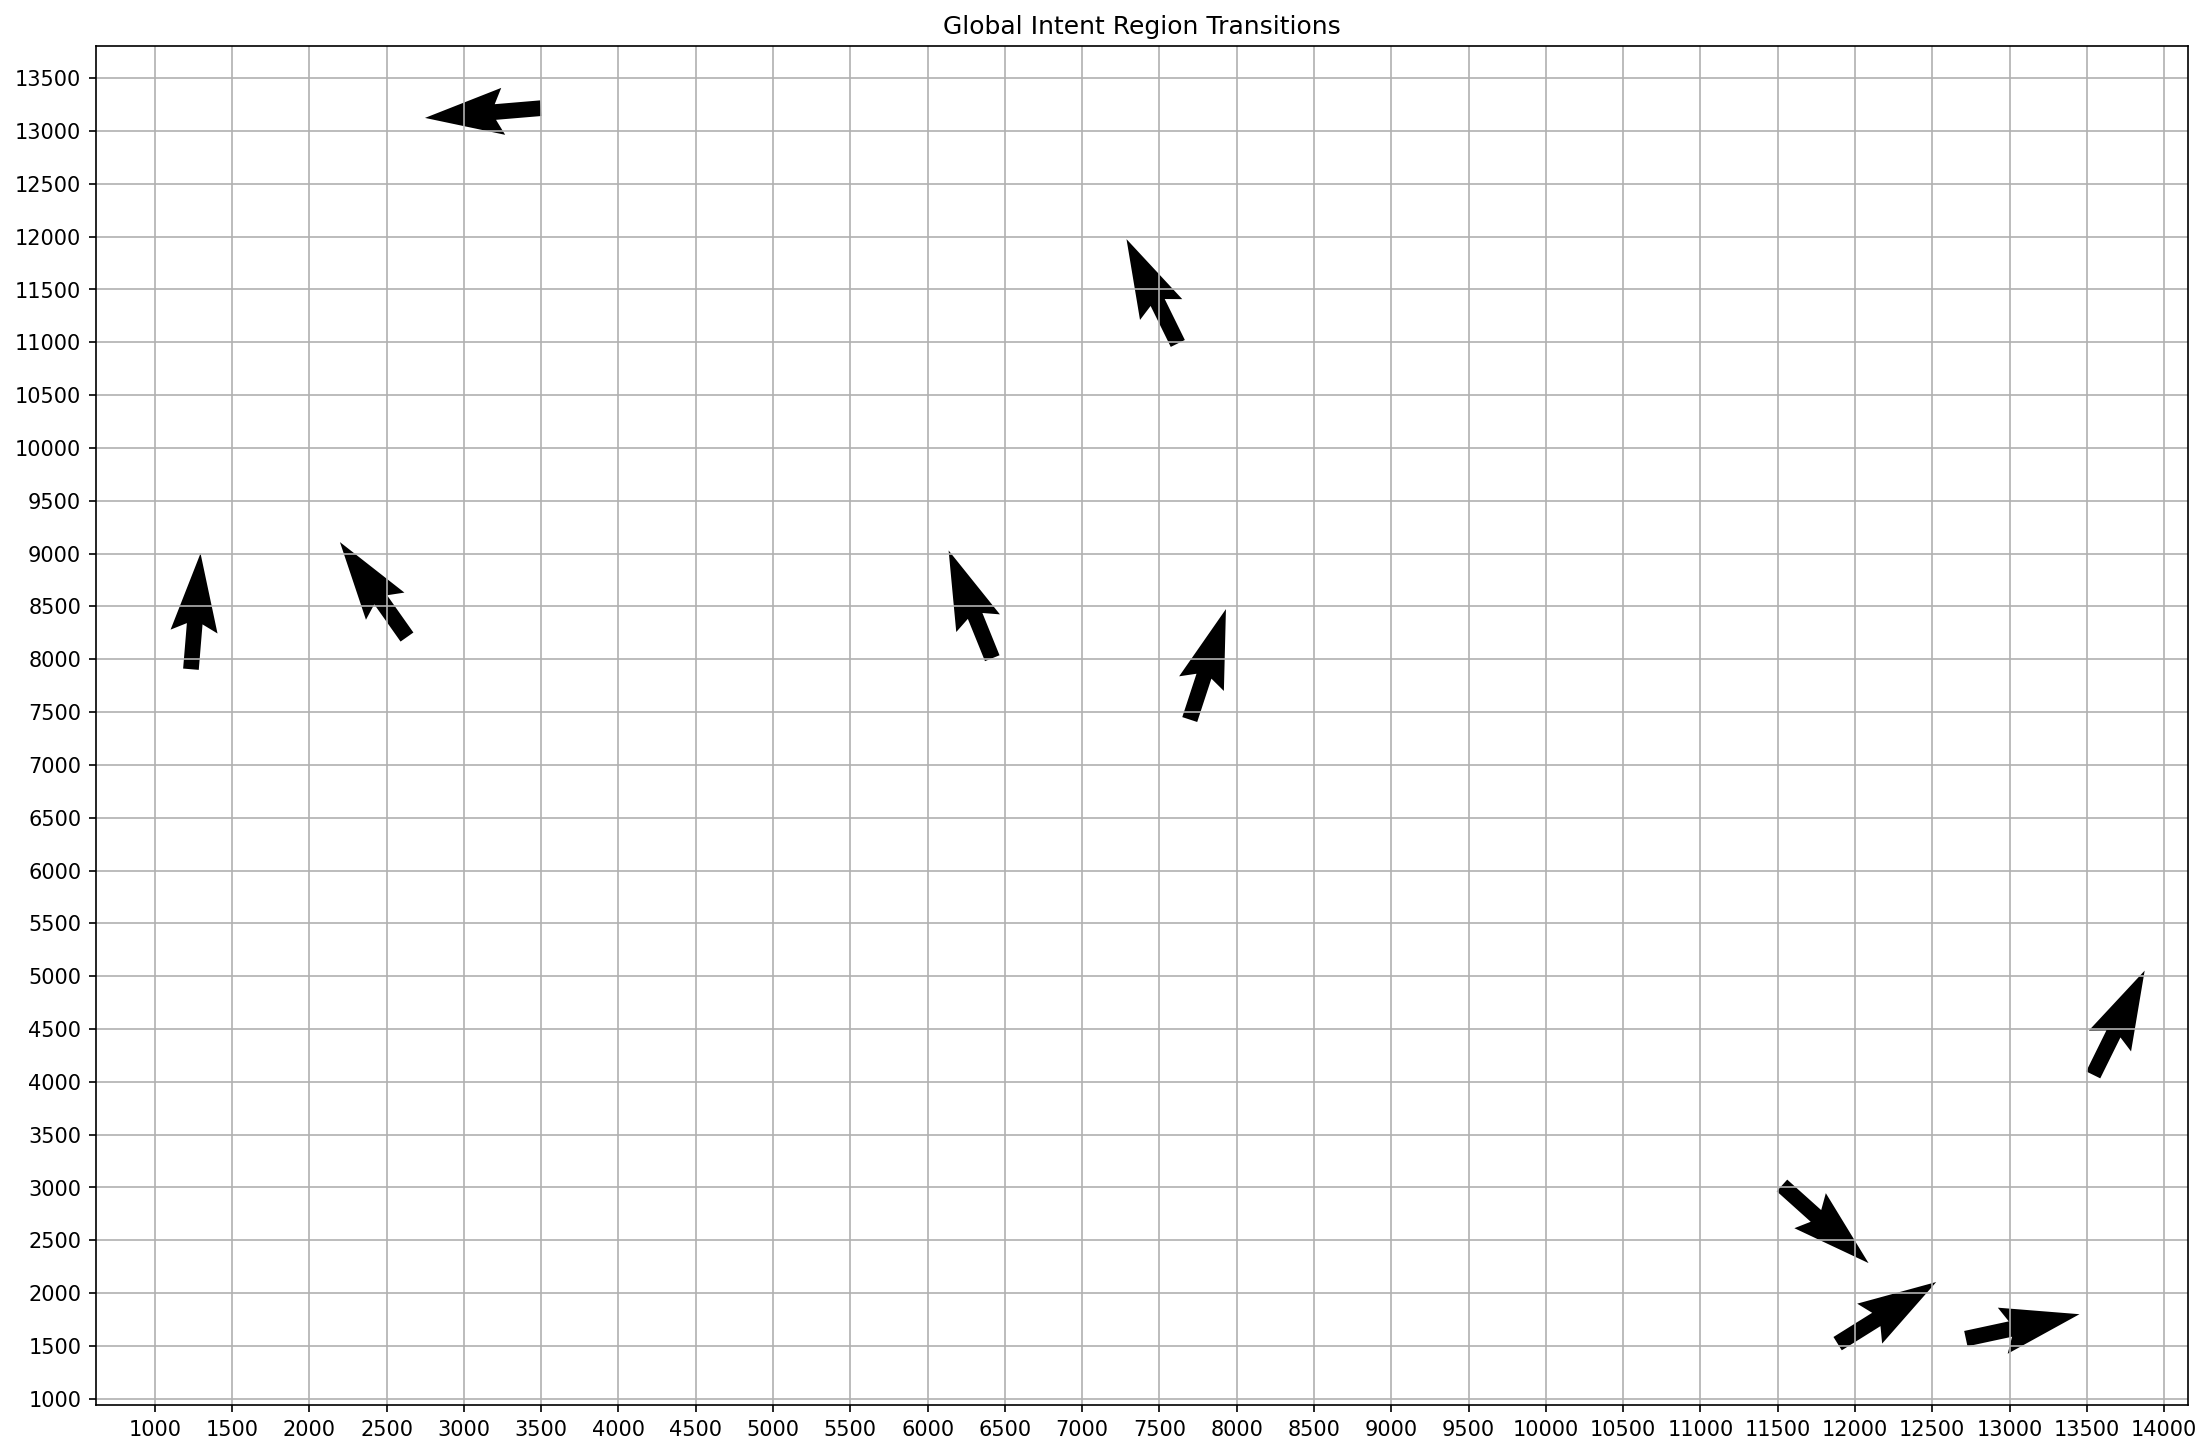

In [291]:
import numpy as np
def plot_map_global_quiver(champ_list, intervals):
    #champ_names_for_game = champs_corrected.keys()
    print('champ name list:', champ_list)
    
    fig, ax = plt.subplots()
    
    intervals = intervals
    loc = plticker.MultipleLocator(base=intervals)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    
    """
    for c in champs_corrected:
      plt.plot(champs_corrected[c].pos_x, champs_corrected[c].pos_z)
    """

    # remove (0, 0) rows from a champ
    
    plt.title("Global Intent Region Transitions")
    
    cs = list(champ_list)
    # cs = ["jinx", "varus"]
    # colors = ["b", "r"]
    for i, c in enumerate(cs):
        #new_c = champs_corrected[c][champs_corrected[c].pos_x > 0]
        #new_c = champs_corrected[c][champs_corrected[c].pos_y > 0]
        #plt.plot(new_c.pos_x, new_c.pos_z)
        # ax.plot(champs_corrected[c].pos_x, champs_corrected[c].pos_z)
        STEP = (10 * 480) + (8*5)
        x = champs_corrected[c].prev_pos_x.iloc[STEP]
        y = champs_corrected[c].prev_pos_z.iloc[STEP]
        u = (champs_corrected[c].prev_pos_x - champs_corrected[c].pos_x).iloc[STEP]
        v = (champs_corrected[c].prev_pos_z - champs_corrected[c].pos_z).iloc[STEP]
        #ax.scatter(champs_corrected[c].pos_x, champs_corrected[c].pos_z, s=1)
        ax.quiver(x, y, u, v) #, color=colors[i])
    
champ_names = champs_corrected.keys()
plot_map_global_quiver(champ_names, global_intent_region_size)

## View Global Intent Regions as Scatter Plot (Specific Minute)

champ name list: dict_keys(['varus', 'jayce', 'hecarim', 'ornn', 'darius', 'lux', 'twistedfate', 'zilean', 'udyr', 'jinx'])


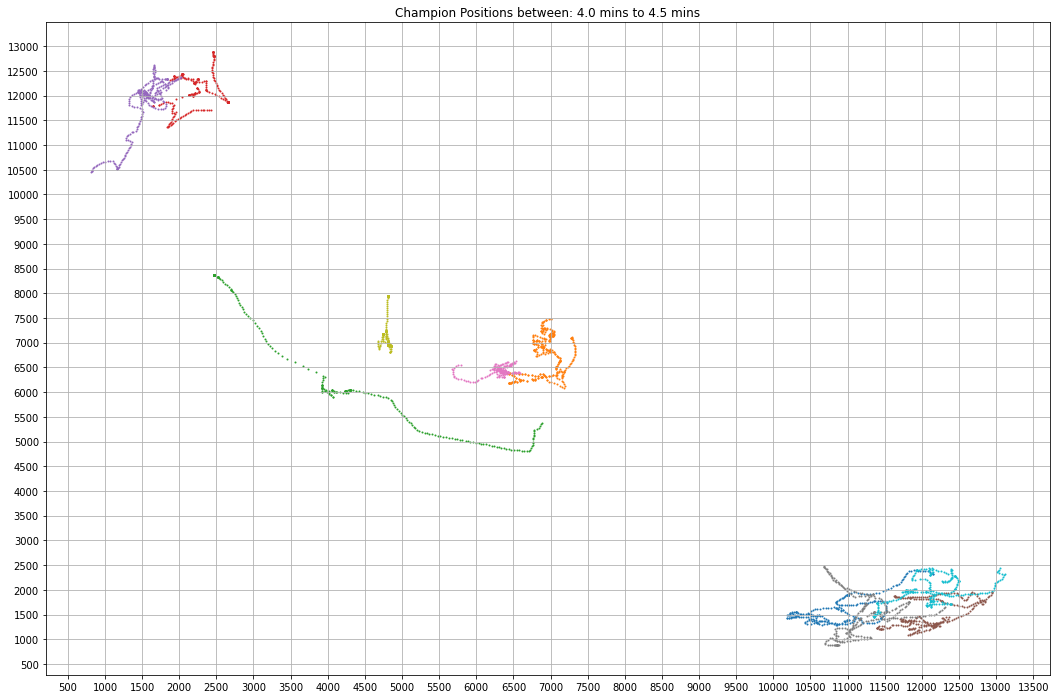

In [13]:
def plot_map_global_scatter_timestep(timestep, champ_list, intervals, seconds=60.0):
    #champ_names_for_game = champs_corrected.keys()
    print('champ name list:', champ_list)
    
    timestep *= seconds
    fig, ax = plt.subplots()
    
    intervals = intervals
    loc = plticker.MultipleLocator(base=intervals)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    
    """
    for c in champs_corrected:
      plt.plot(champs_corrected[c].pos_x, champs_corrected[c].pos_z)
    """

    # remove (0, 0) rows from a champ
    
    plt.title(f"Champion Positions between: {timestep / 60.0} mins to {(timestep + seconds) / 60.0} mins")
    
    cs = list(champ_list)
    #cs = ["kindred"]
    for c in cs:
        #new_c = champs_corrected[c][champs_corrected[c].pos_x > 0]
        #new_c = champs_corrected[c][champs_corrected[c].pos_y > 0]
        #plt.plot(new_c.pos_x, new_c.pos_z)
        # ax.plot(champs_corrected[c].pos_x, champs_corrected[c].pos_z)
        cur_champ = \
            champs_corrected[c][champs_corrected[c].time > timestep]
        cur_champ = \
            cur_champ[cur_champ.time < timestep + seconds]
        
        ax.scatter(cur_champ.pos_x, cur_champ.pos_z, s=1)
    
champ_names = champs_corrected.keys()
plot_map_global_scatter_timestep(8, champ_names, global_intent_region_size, seconds=30)


## Animate Scatter Plot over Global Intent Regions (over Time)

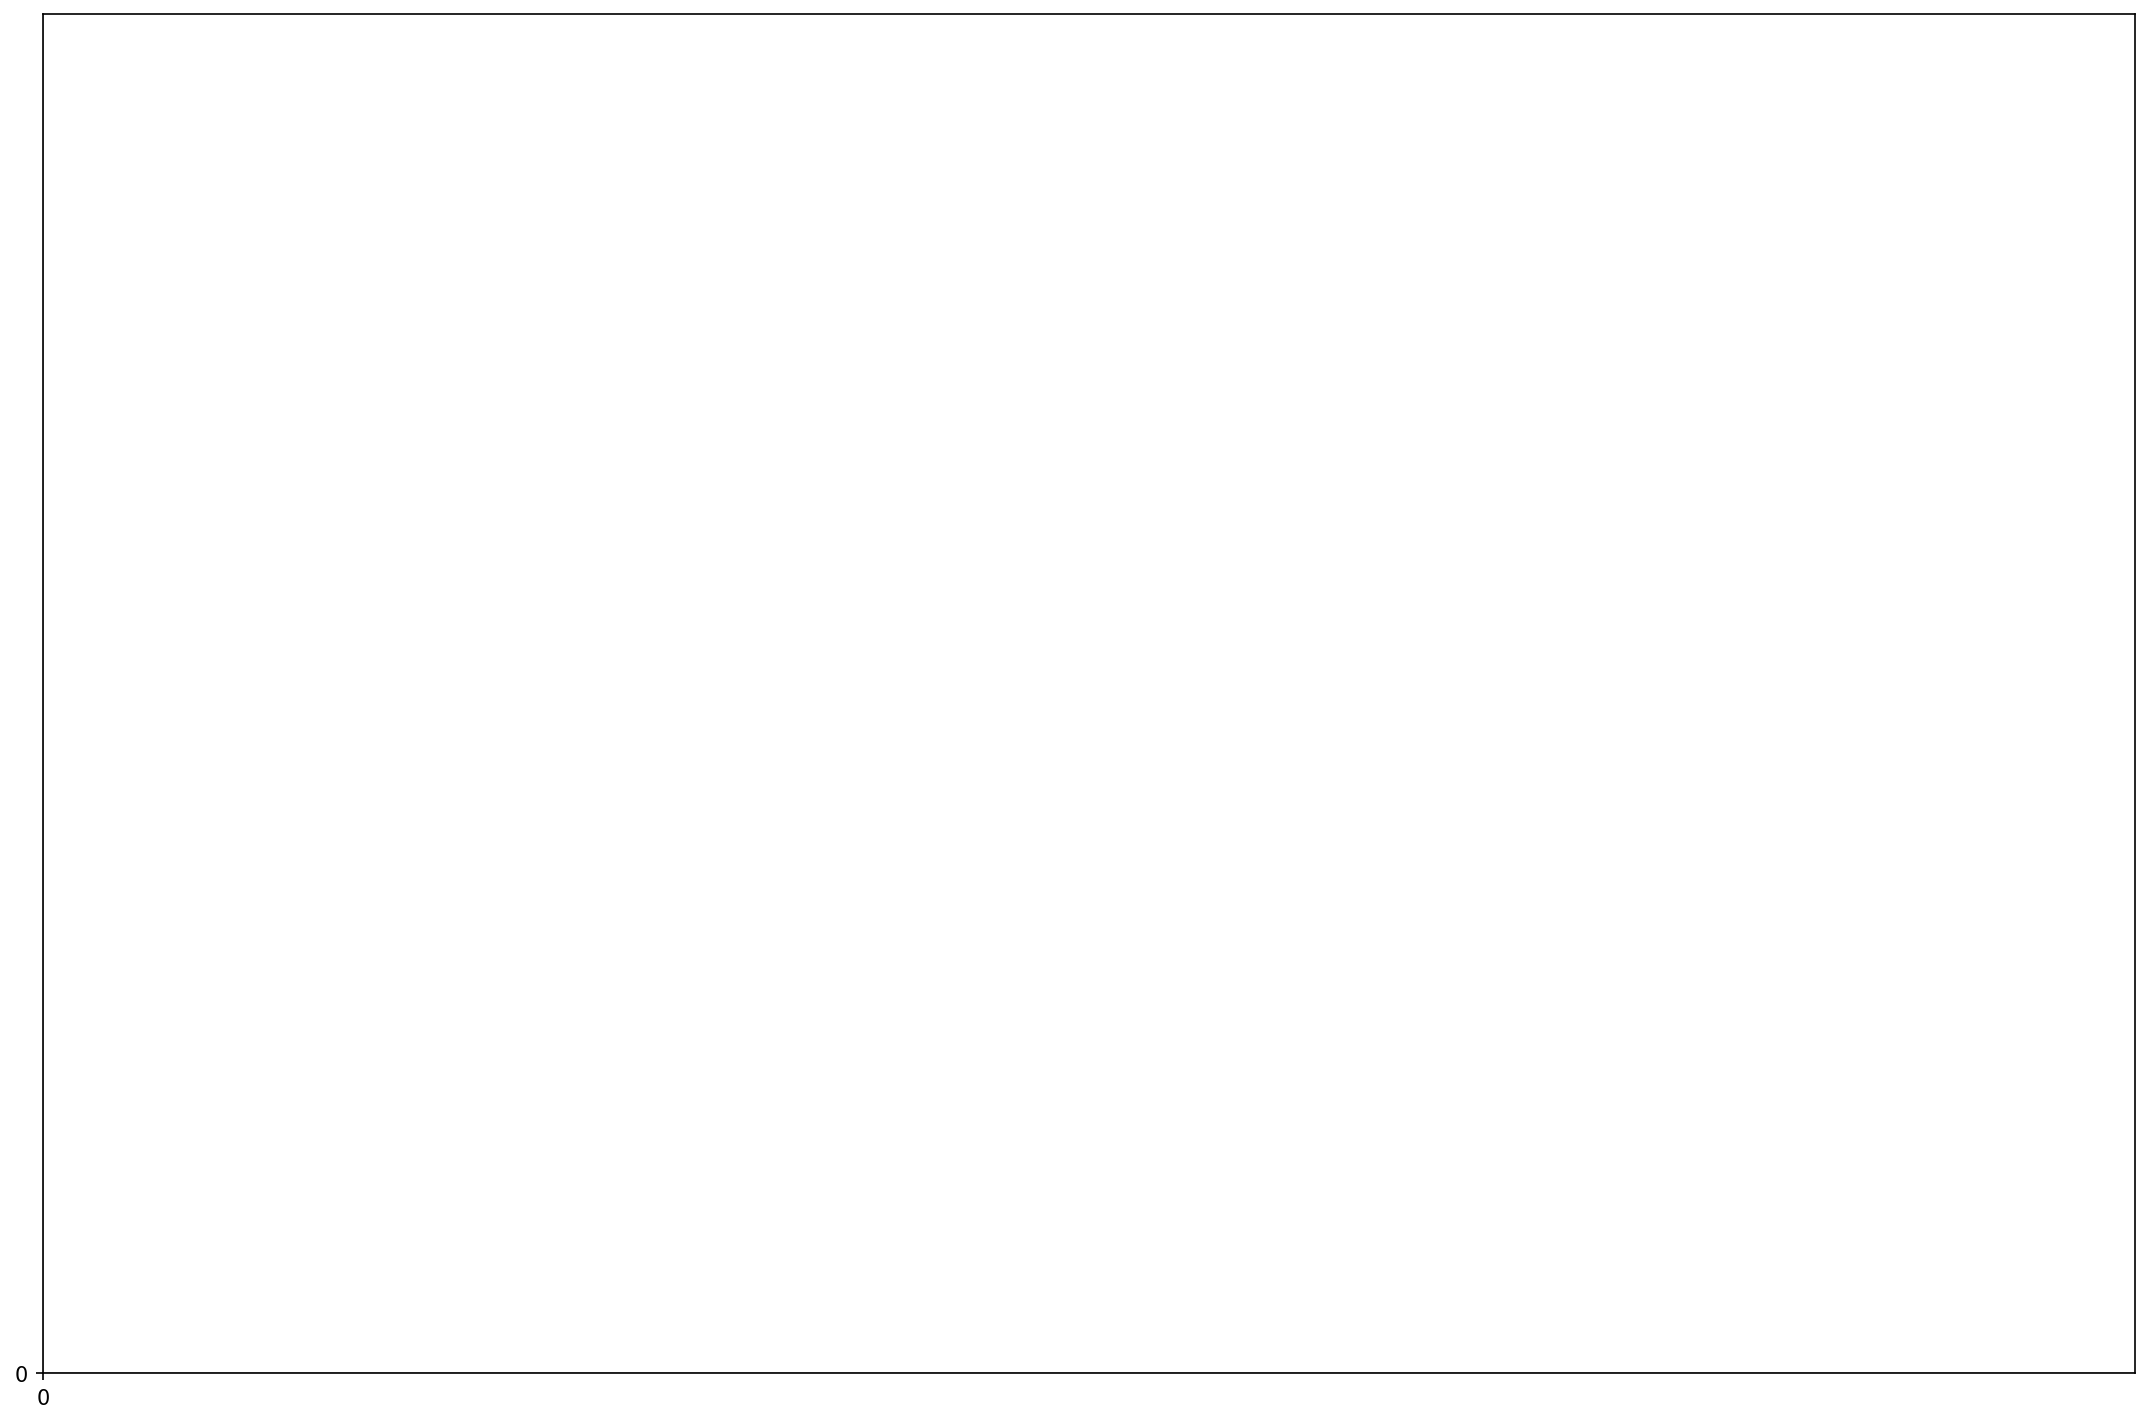

In [14]:
anim = False # false by default as it's memory-heavy
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

intervals = global_intent_region_size
loc = plticker.MultipleLocator(base=intervals)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(axis='both', linestyle='-')

seconds = 60.0

def animate(t):
    ax.cla()
    timestep = float(t) * seconds
    plt.title(f"Champion Positions between: {timestep / 60.0} mins to {(timestep + seconds) / 60.0} mins")
    print('t:', t)
    for c in cs:
        #new_c = champs_corrected[c][champs_corrected[c].pos_x > 0]
        #new_c = champs_corrected[c][champs_corrected[c].pos_y > 0]
        #plt.plot(new_c.pos_x, new_c.pos_z)
        # ax.plot(champs_corrected[c].pos_x, champs_corrected[c].pos_z)
        cur_champ = \
            champs_corrected[c][champs_corrected[c].time > 0]
        cur_champ = \
            cur_champ[cur_champ.time < timestep + seconds]
        ax.scatter(cur_champ.pos_x, cur_champ.pos_z, s=1)
    #ax.plot()
    
if anim:
    anim_frames = int(math.ceil(df["time"].max() / seconds) / 2)
    # anim_frames = 2
    matplotlib.animation.FuncAnimation(fig, animate, frames=anim_frames)

# View Transitions Between Global Intent Regions

## Display Heatmap (each position occurrence within each Region, Unnormalised & Log10 Normalised)

### Unnormalised Heatmap

[[839. 208.  15. ...   0.   0.   0.]
 [220. 909. 758. ...   0.   0.   0.]
 [ 10. 324. 108. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


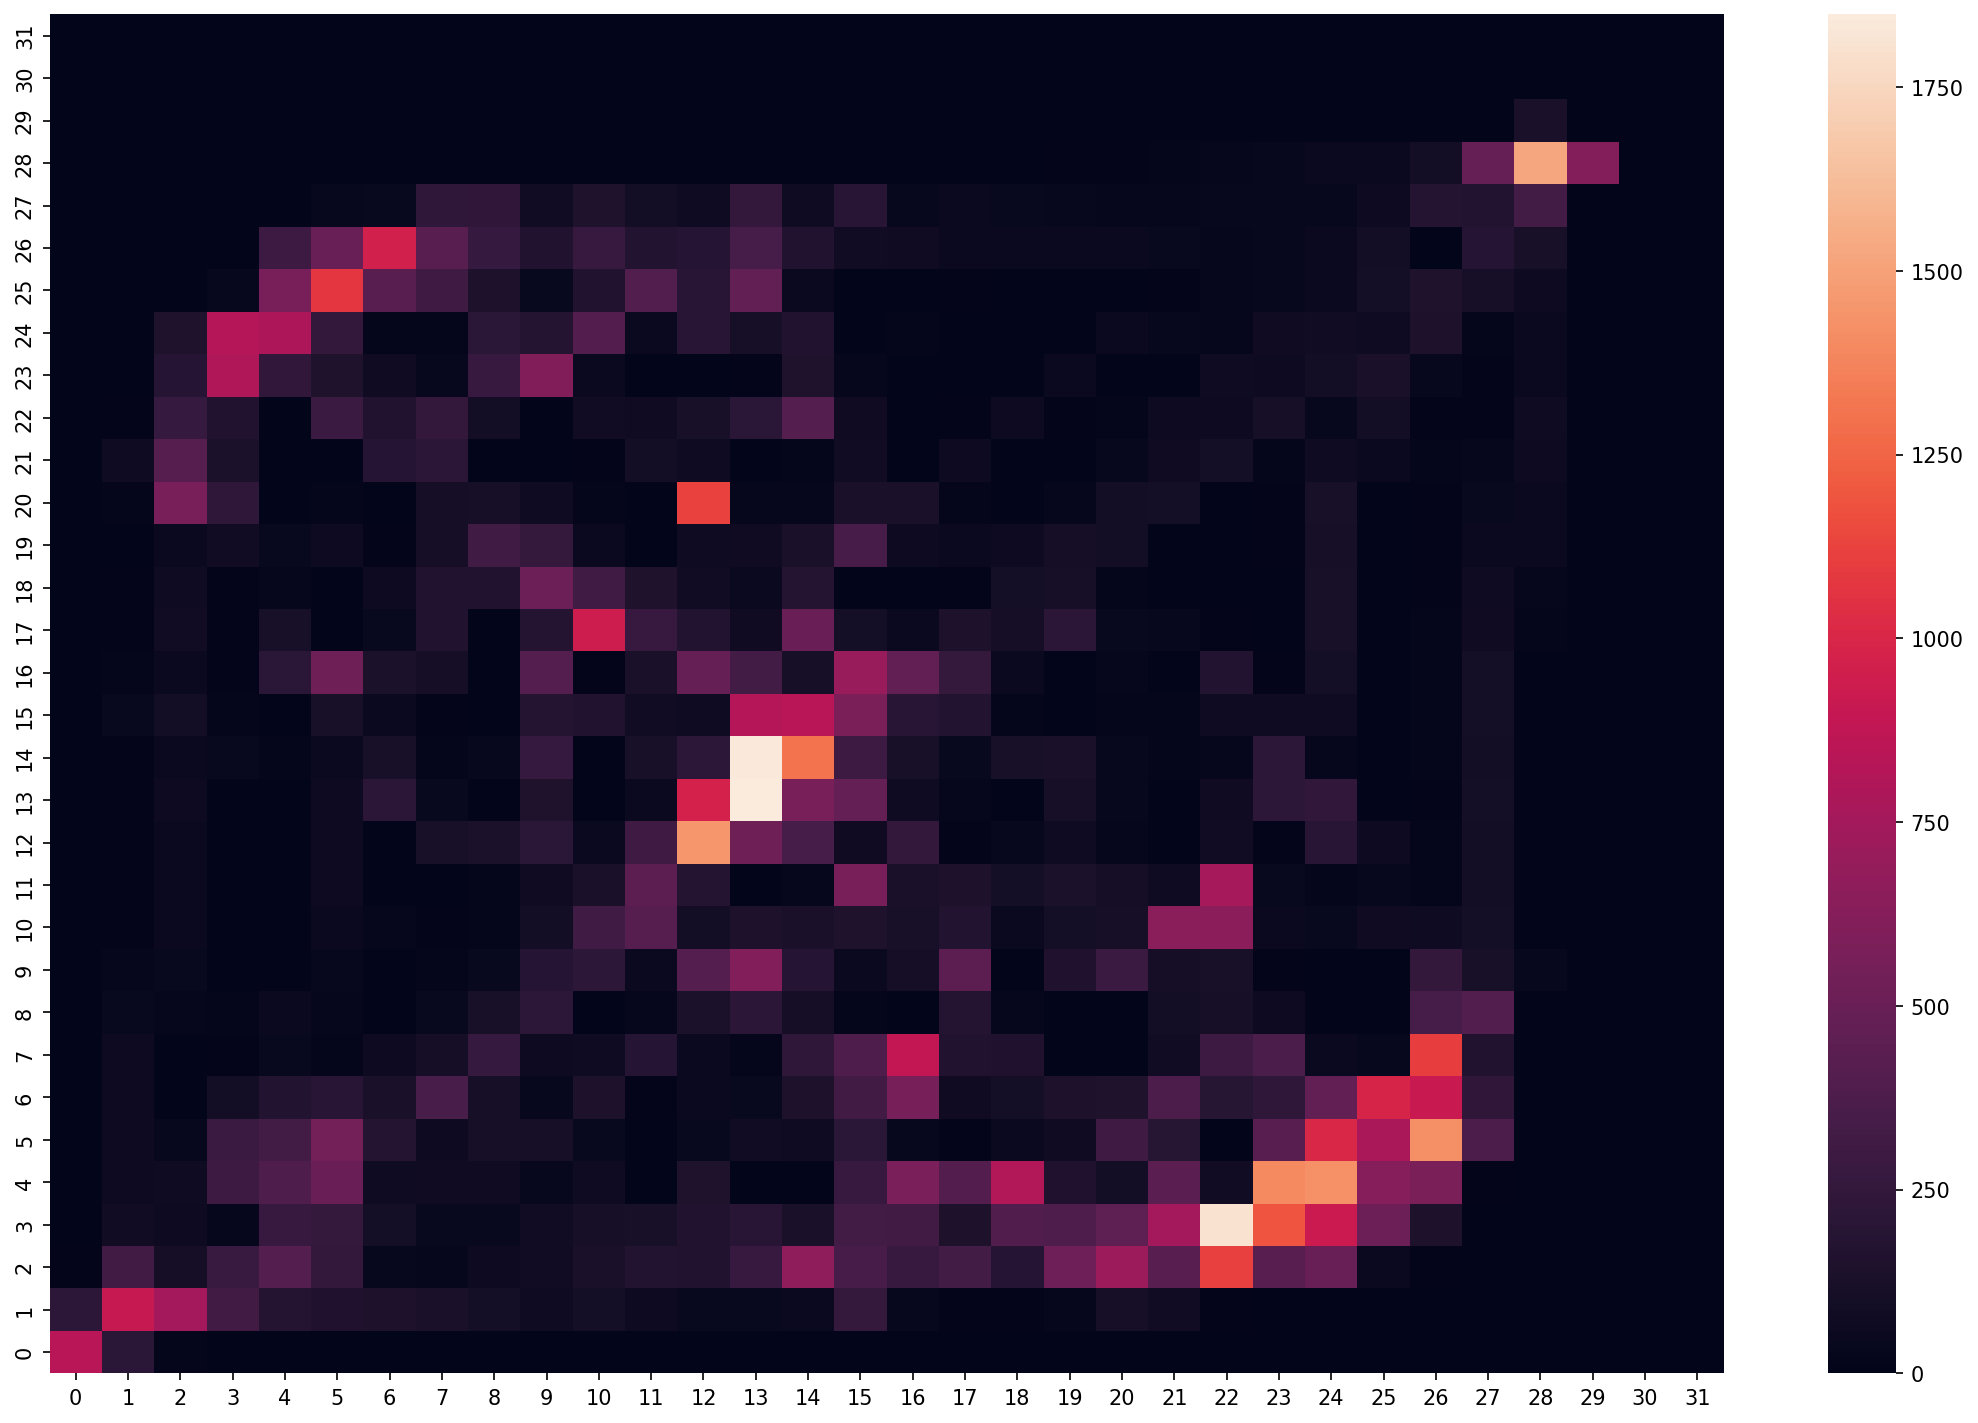

In [15]:
import math
import sys
def global_heatmap(cs):
    # NOTE: Numpy addressing is [row, col] || [y, x]
    import seaborn as sns
    from numpy import interp
    global_intent_sum_matrix = np.zeros((map_n, map_n))
    #%%timeit
    def inc_global_region(row, global_intent_sum_matrix):
        # Gets `N` global intent region for current row for champ
        x_n = math.floor(interp(row.pos_x, [0, 16000], [0, map_n]))
        y_n = math.floor(interp(row.pos_z, [0, 16000], [0, map_n]))
        global_intent_sum_matrix[y_n, x_n] += 1

    for c in cs:
        champs_corrected[c].apply(lambda row: inc_global_region(row, global_intent_sum_matrix), axis=1)

    #import sys
    #import numpy as np
    np.set_printoptions(threshold=8)
    # global_intent_sum_matrix = np.log(global_intent_sum_matrix)

    result = global_intent_sum_matrix

    # global_intent_sum_matrix /= 8 # convert from 8hz to 1hz
    print(result)
    ax = sns.heatmap(result)
    ax.invert_yaxis()
    return result, global_intent_sum_matrix

champ_names = champs_corrected.keys()
result, global_intent_sum_matrix = global_heatmap(champ_names)

### Normalised Heatmap (Log10)

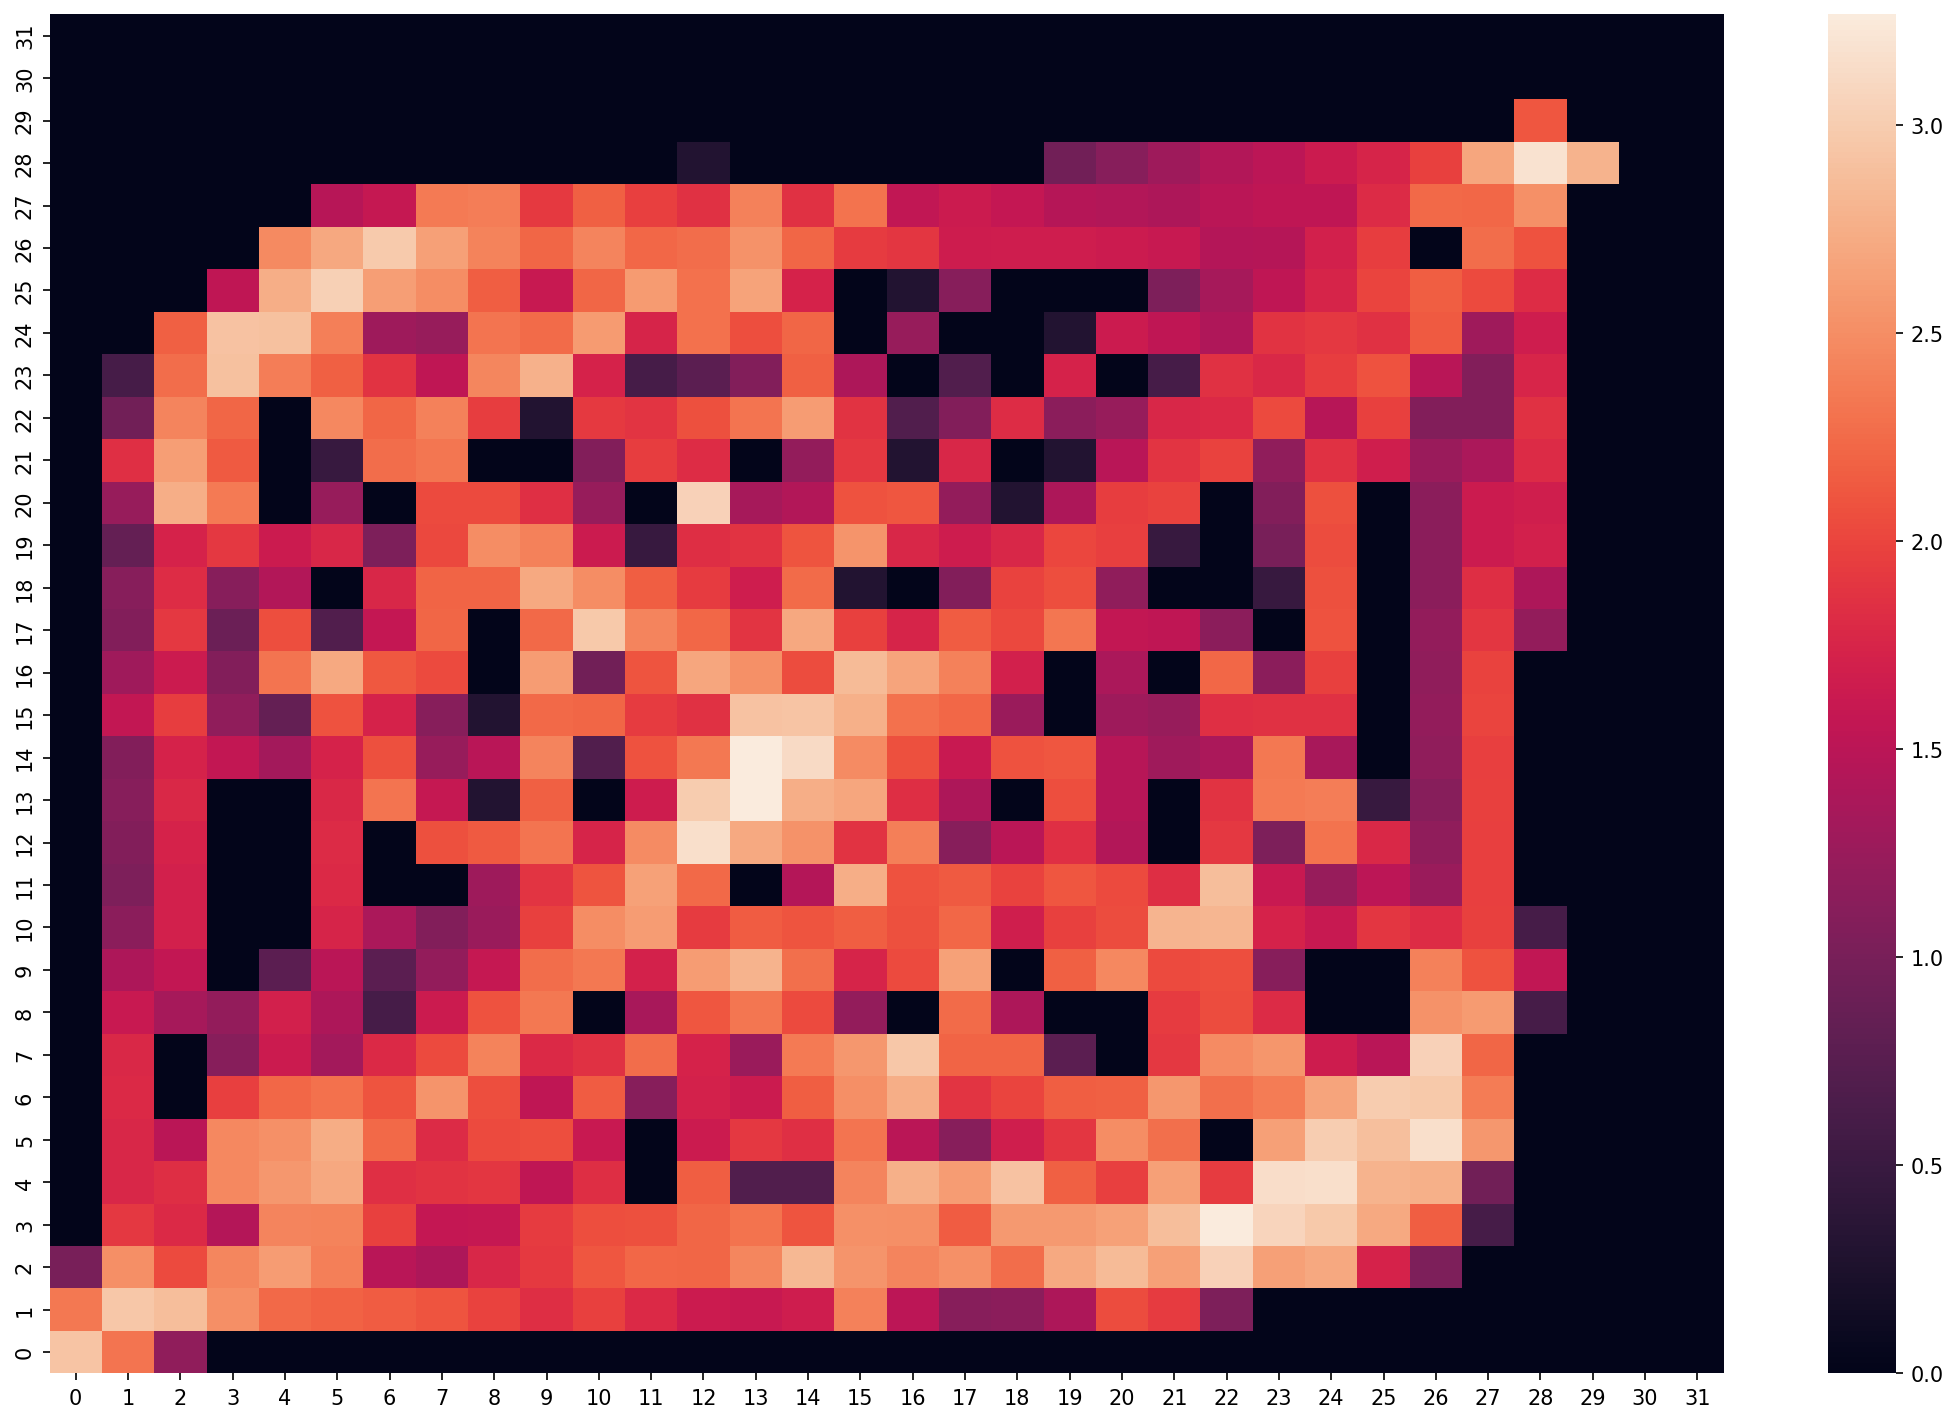

In [17]:
import seaborn as sns
def global_heatmap_normalised(cs, result):
    result = np.where(global_intent_sum_matrix > 0.0000001, global_intent_sum_matrix, 0)
    np.log10(result, out=result, where=result > 0)

    ax = sns.heatmap(result)
    ax.invert_yaxis()
global_heatmap_normalised(champ_names, result)

# Split Champ Positions into Local Intent Regions

## Set Local Intent Region Settings

In [18]:
map_m = int(global_intent_region_size / 50)
local_intent_region_size = int(global_intent_region_size / map_m)
print("Local Region Count, Local Region Size:", map_m, (global_intent_region_size, global_intent_region_size))

Local Region Count, Local Region Size: 10 (500, 500)


## Get Global Intent Region with Highest Movement Activity

In [19]:
highest_activity_1d = result.argmax()
print("1D-index of highest activity region:", highest_activity_1d)

1D-index of highest activity region: 429


In [20]:
from numpy import unravel_index
highest_activity_2d = \
    unravel_index(global_intent_sum_matrix.argmax(), global_intent_sum_matrix.shape)
highest_activity_2d

(13, 13)

## Plot Global Intent Region with Highest Movement Activity

champ name list: dict_keys(['varus', 'jayce', 'hecarim', 'ornn', 'darius', 'lux', 'twistedfate', 'zilean', 'udyr', 'jinx'])
6500 6500
6500 6500
6500 6500
6500 6500
6500 6500
6500 6500
6500 6500
6500 6500
6500 6500
6500 6500
total number of points in local region: 1849


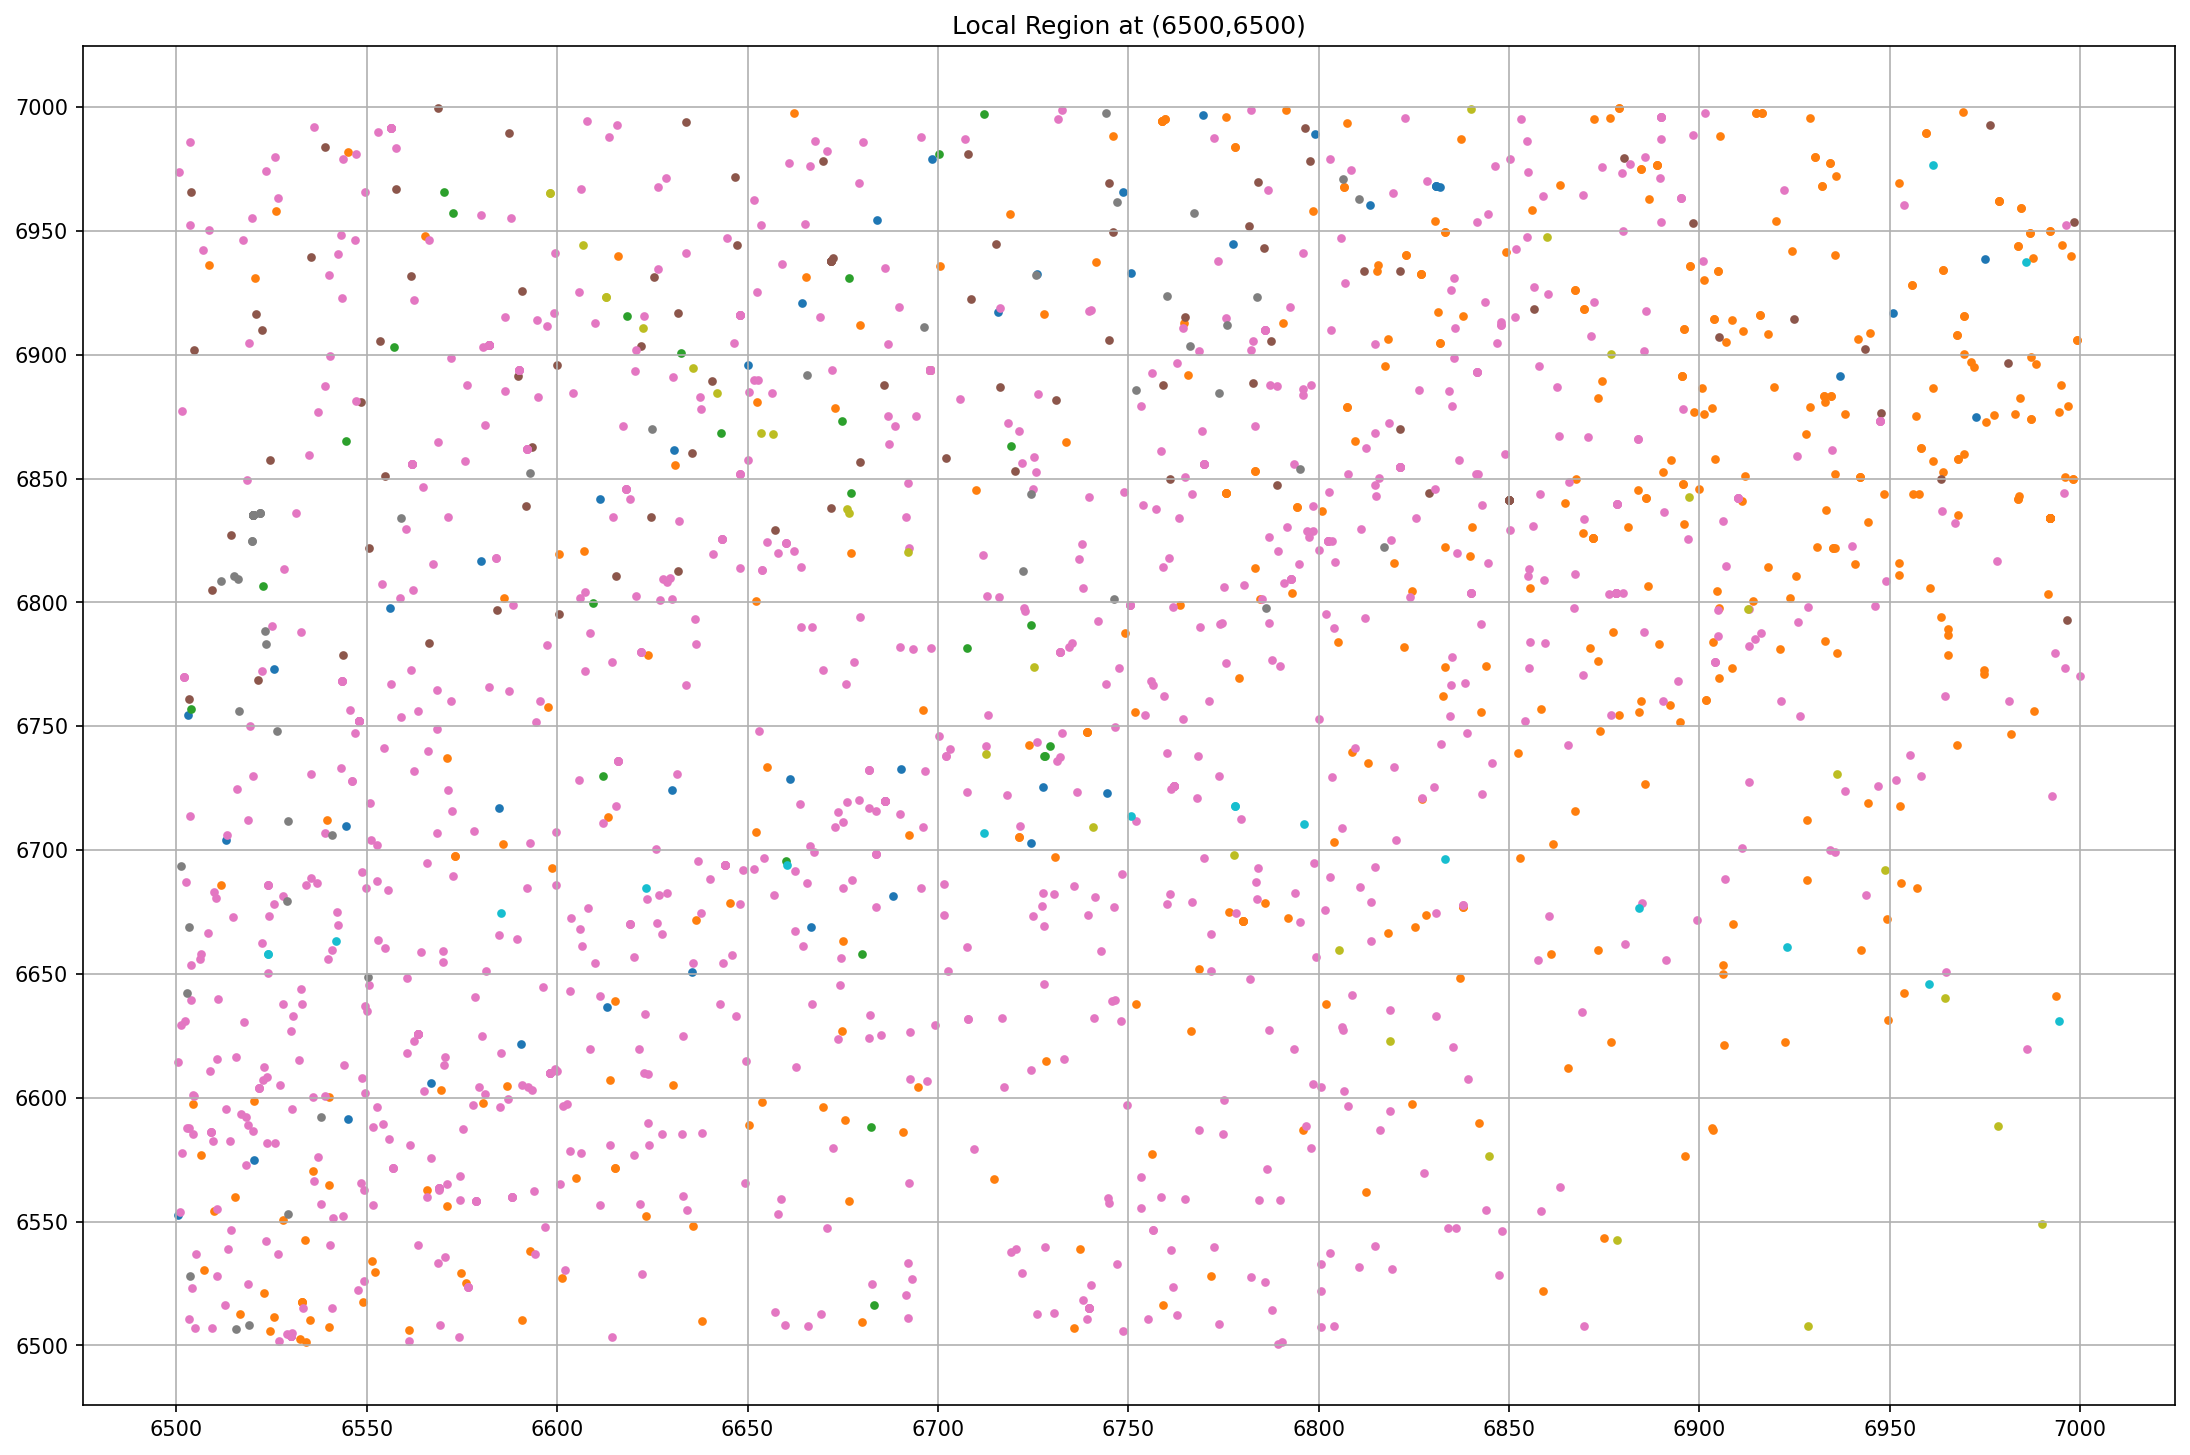

In [21]:
def get_local_actions(row, x_off, y_off):
    # global_intent_region_size
    x = row.pos_x
    y = row.pos_z
    #print(x, y)
    if   x < x_off or x > x_off + global_intent_region_size * 1:
        return False
    elif y < x_off or y > x_off + global_intent_region_size * 1:
        return False
    else:
        return True

def get_local_actions_only(x_off, y_off, champ_series):
    print(x_off, y_off)
    x_start = x_off
    x_end   = x_off + global_intent_region_size
    y_start = y_off
    y_end   = y_off + global_intent_region_size
    mask = champ_series.apply(lambda row:\
                              get_local_actions(row, x_off, y_off), axis=1)
    champ_series = champ_series[mask]
    return champ_series
    
def plot_map_local_scatter(champ_list, intervals, pos):
    print('champ name list:', champ_list)
    
    fig, ax = plt.subplots()
    
    intervals = intervals
    loc = plticker.MultipleLocator(base=intervals)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    
    plt.title(f"Local Region at ({pos[0]*global_intent_region_size},{pos[1]*global_intent_region_size})")

    # remove (0, 0) rows from a champ

    cs = list(champ_list)
    lens = 0
    for c in cs:
        cur_champ = get_local_actions_only(
            x_off=pos[0] * global_intent_region_size,
            y_off=pos[1] * global_intent_region_size,
            champ_series=champs_corrected[c],
        )
        lens += len(cur_champ)
        ax.scatter(cur_champ.pos_x, cur_champ.pos_z, s=10)
    print("total number of points in local region:", lens)
    
champ_names = champs_corrected.keys()
plot_map_local_scatter(
    champ_names,
    local_intent_region_size,
    highest_activity_2d)

# View Transitions Between Local Intent Regions

## Display Heatmap (each position occurrence within each Region, Unnormalised & Log10 Normalised)

### Unnormalised Heatmap

x_off, y_off: 6500 6500
6500 6500
x_off, y_off: 6500 6500
6500 6500
x_off, y_off: 6500 6500
6500 6500
x_off, y_off: 6500 6500
6500 6500
x_off, y_off: 6500 6500
6500 6500
x_off, y_off: 6500 6500
6500 6500
x_off, y_off: 6500 6500
6500 6500
x_off, y_off: 6500 6500
6500 6500
x_off, y_off: 6500 6500
6500 6500
x_off, y_off: 6500 6500
6500 6500
[[46. 18.  6. ...  4.  1.  1.]
 [40. 35. 21. ...  3.  2.  1.]
 [33. 35. 16. ...  3.  4.  6.]
 ...
 [ 9. 26. 18. ... 15. 26. 25.]
 [14. 25. 25. ... 20. 19. 21.]
 [16. 17.  8. ... 36. 16. 16.]]


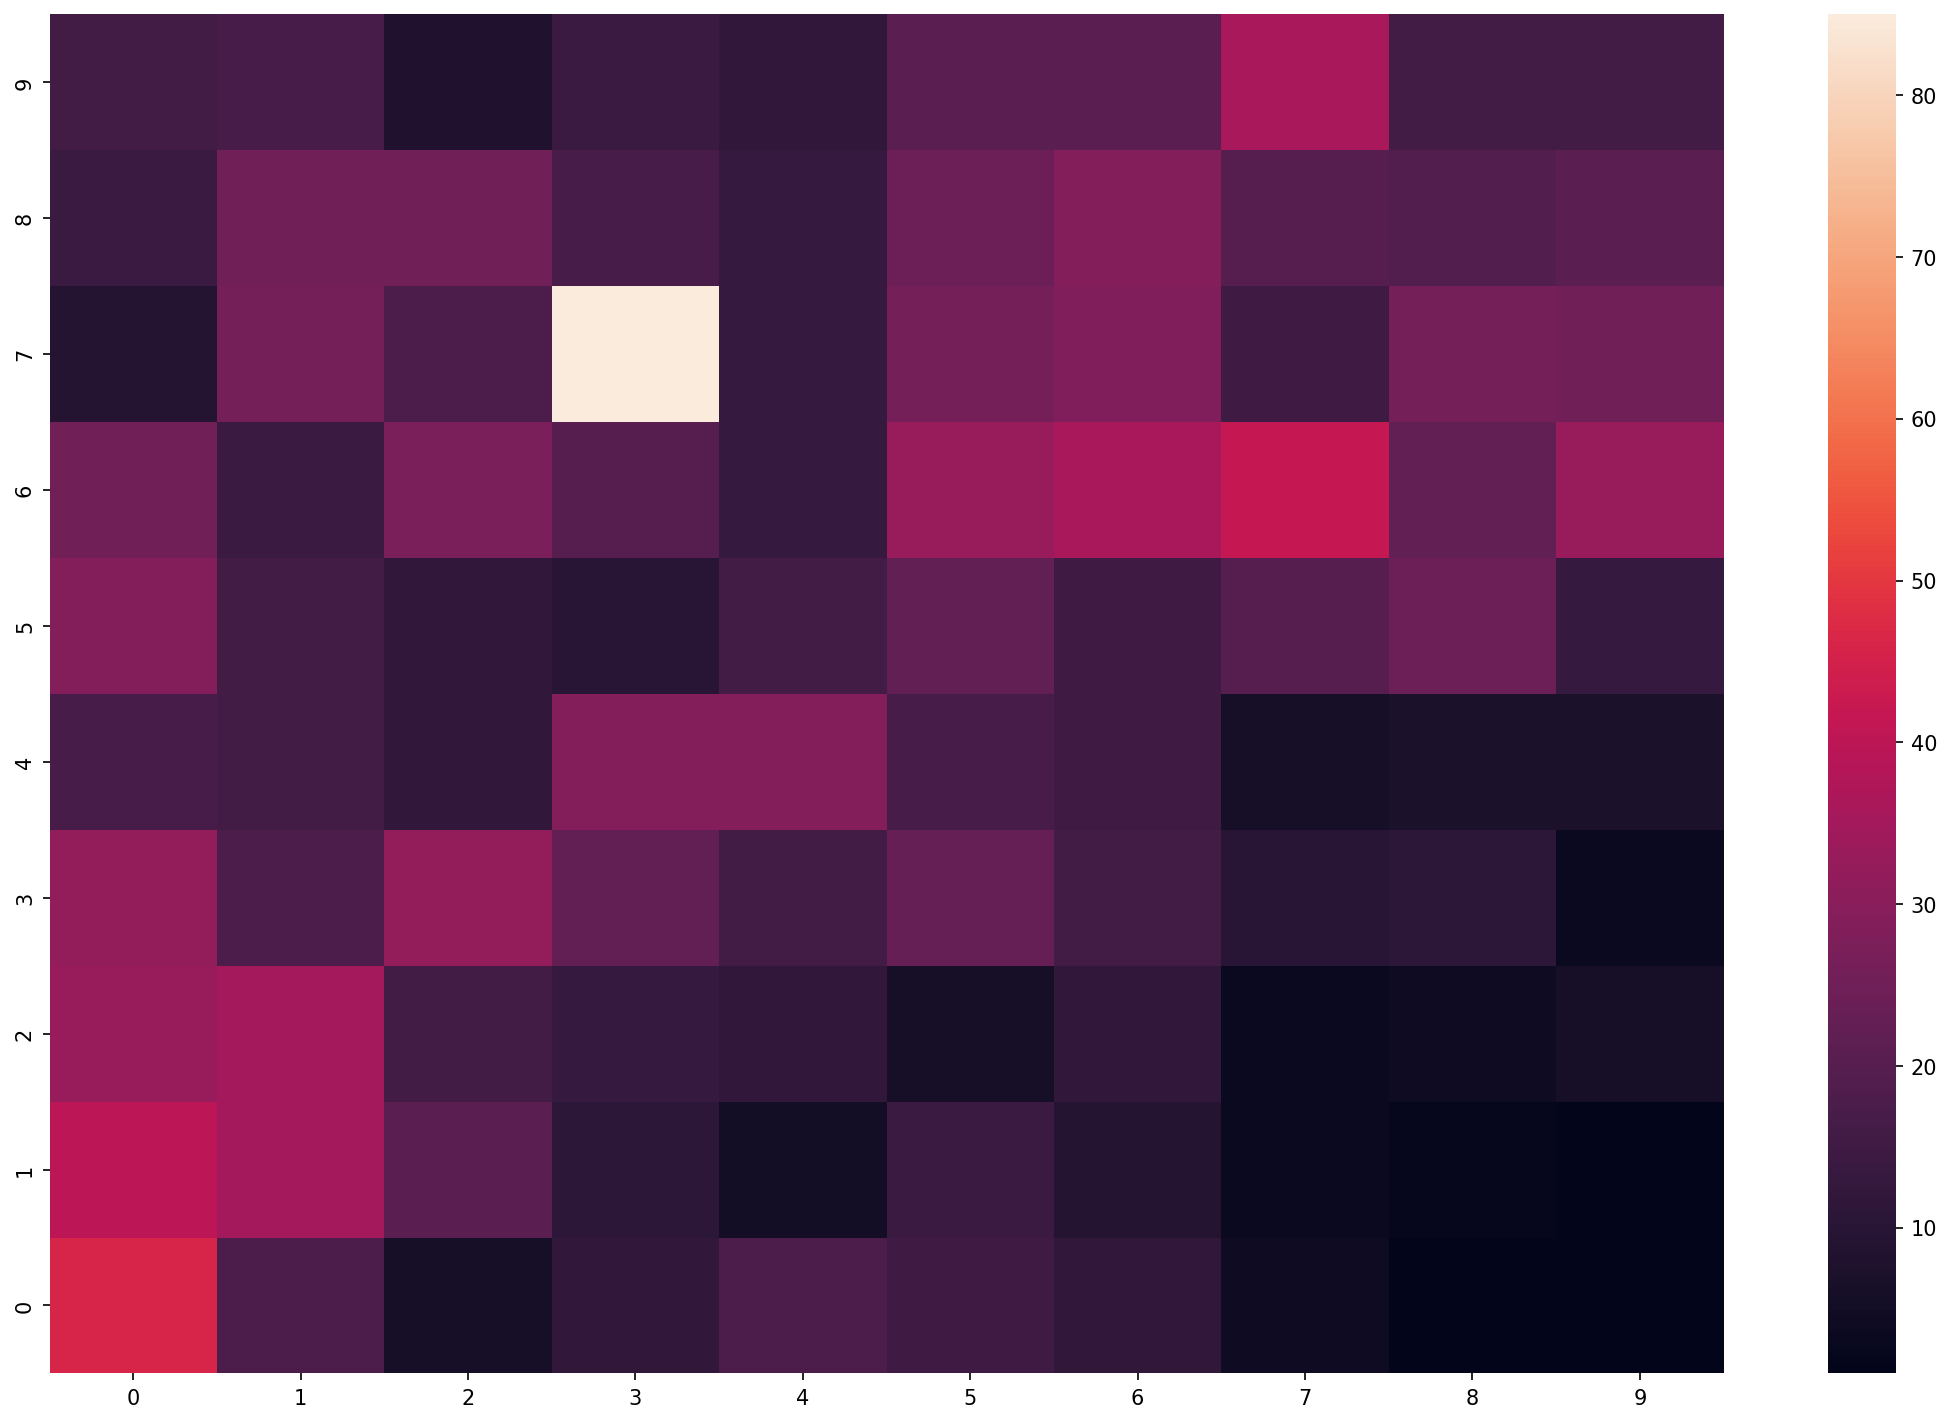

In [31]:
import math
def local_heatmap(cs, pos):
    # NOTE: Numpy addressing is [row, col] || [y, x]
    import seaborn as sns
    from numpy import interp
    local_intent_sum_matrix = np.zeros((map_m, map_m))
    #%%timeit
    def inc_local_region_(row, local_intent_sum_matrix, x_off, y_off):
        # Gets `N` global intent region for current row for champ
        x_n = math.floor(interp(row.pos_x, [x_off + 0, x_off + global_intent_region_size], [0, map_m]))
        y_n = math.floor(interp(row.pos_z, [y_off + 0, y_off + global_intent_region_size], [0, map_m]))
        
        # print('x_n, y_n:', x_n, y_n)
        local_intent_sum_matrix[y_n, x_n] += 1

    for c in cs:
        x_off = pos[0] * global_intent_region_size
        y_off = pos[1] * global_intent_region_size
        print("x_off, y_off:", x_off, y_off)
        cur_champ = get_local_actions_only(
            x_off=x_off,
            y_off=y_off,
            champ_series=champs_corrected[c],
        )
        cur_champ.apply(lambda row: inc_local_region_(row, local_intent_sum_matrix, x_off, y_off), axis=1)

    #import sys
    #import numpy as np
    np.set_printoptions(threshold=8)
    # global_intent_sum_matrix = np.log(global_intent_sum_matrix)

    result_ = local_intent_sum_matrix

    # local_intent_sum_matrix /= 8 # convert from 8hz to 1hz
    print(result_)
    ax = sns.heatmap(result_)
    ax.invert_yaxis()
    
    return result_, local_intent_sum_matrix
champ_names = champs_corrected.keys()
result_, local_intent_sum_matrix = local_heatmap(champ_names, highest_activity_2d)


In [23]:
local_intent_sum_matrix

array([[56., 18., 10., ...,  1.,  1.,  0.],
       [50., 53., 20., ...,  3.,  1.,  0.],
       [34., 28., 17., ...,  7.,  8.,  0.],
       ...,
       [13., 32., 33., ..., 26., 25.,  0.],
       [20., 21., 13., ..., 31., 18.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### Normalised Heatmap (Log10)

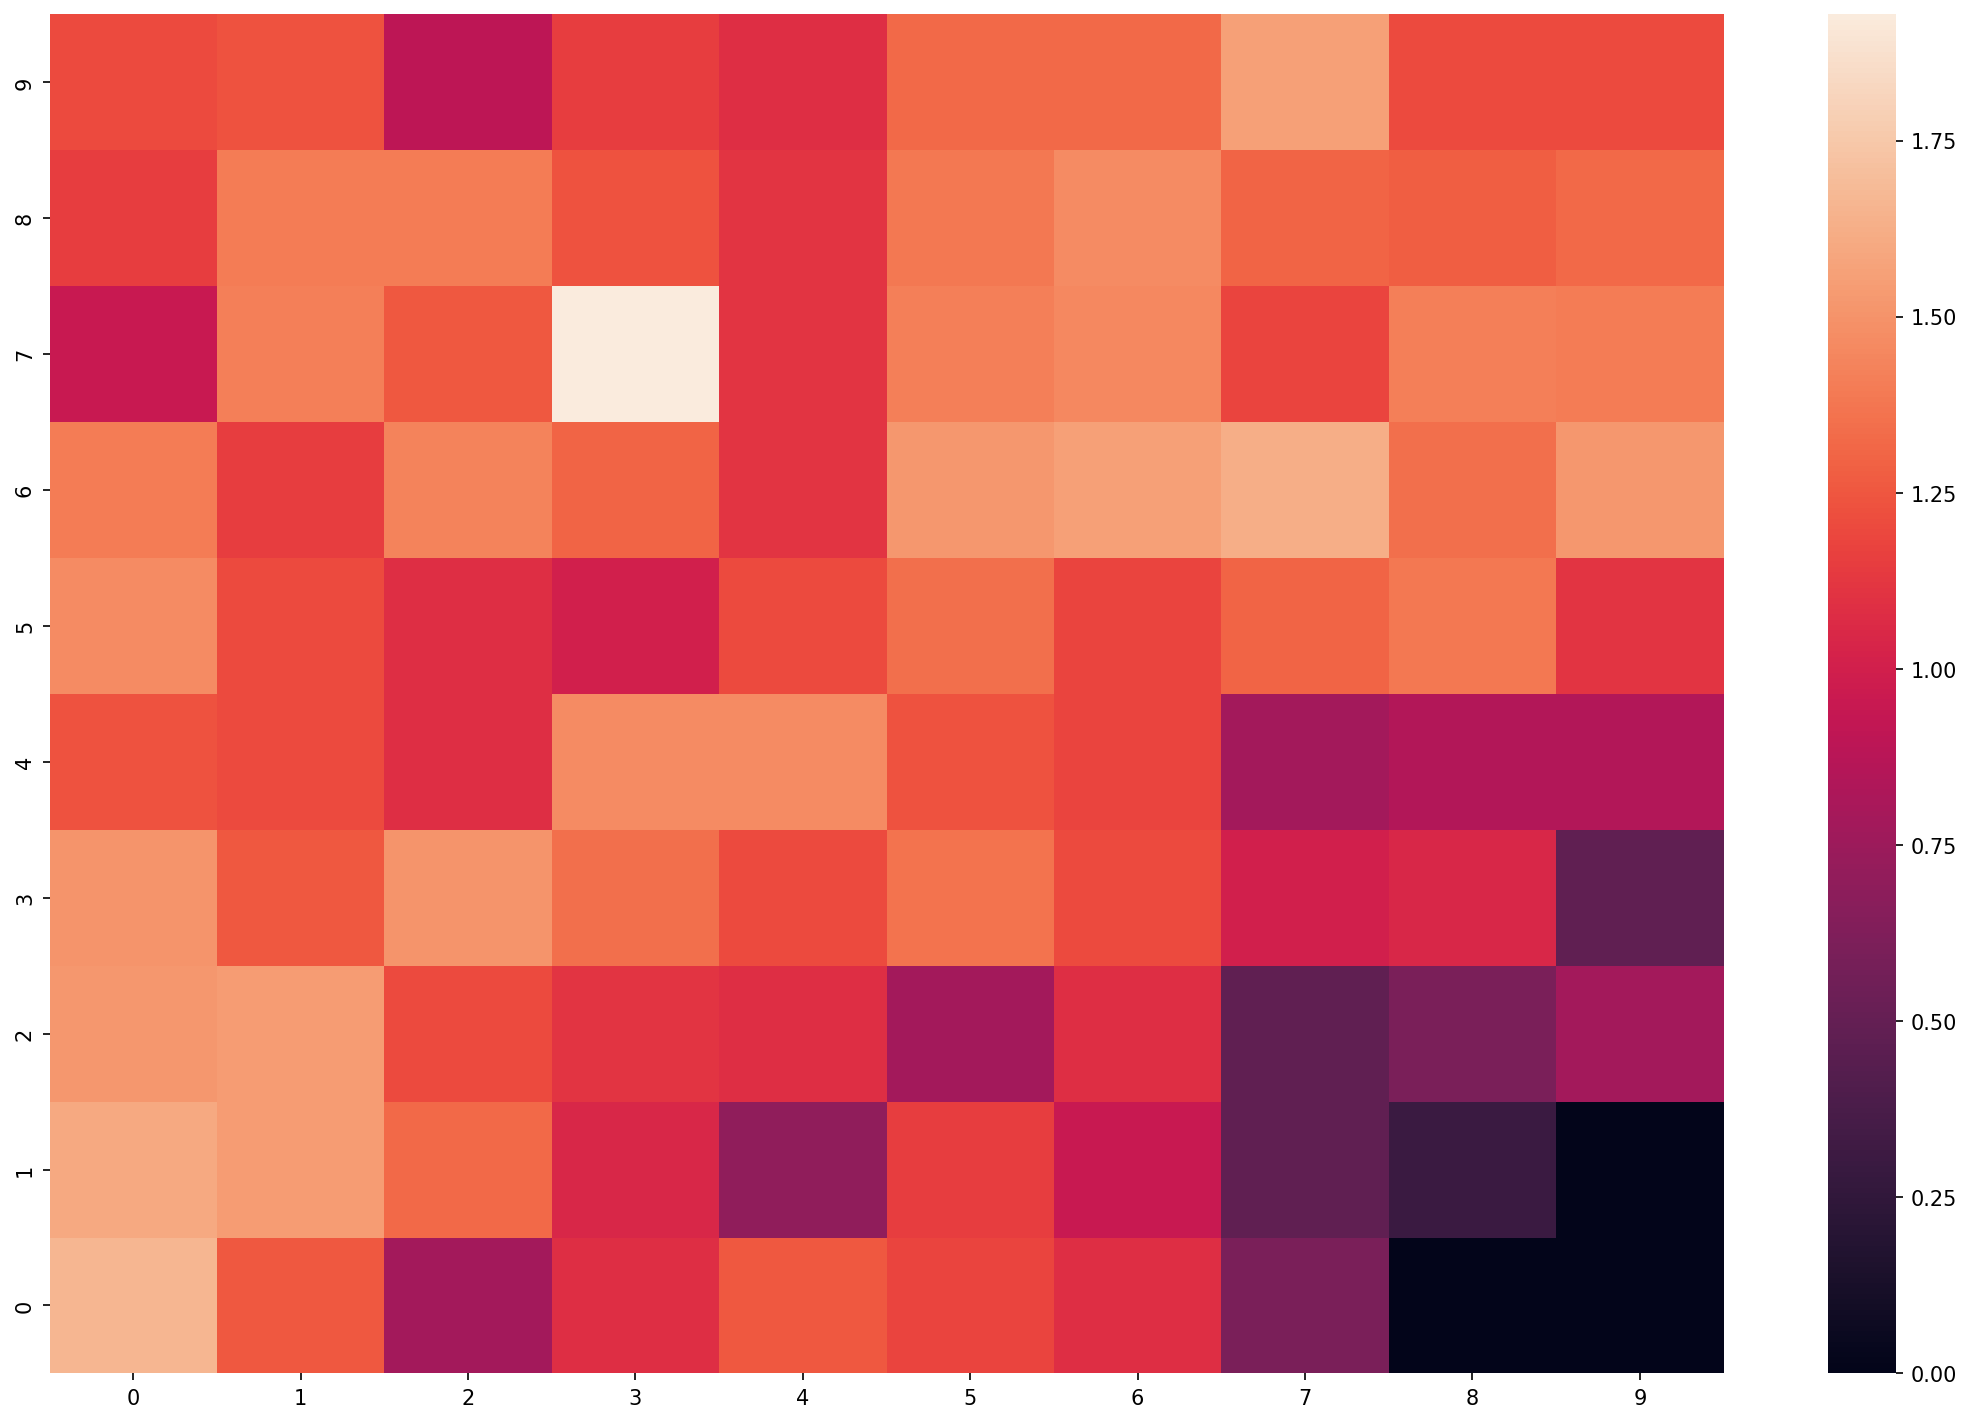

In [32]:
def local_heatmap_normalised(cs, result):
    result = np.where(local_intent_sum_matrix > 0.0000001, local_intent_sum_matrix, 0)
    np.log10(result, out=result, where=result > 0)

    ax = sns.heatmap(result)
    ax.invert_yaxis()
local_heatmap_normalised(champ_names, result_)

# Action Label Classification

## Global/Local Intent Region Movement Transitions

champ name list: dict_keys(['varus', 'jayce', 'hecarim', 'ornn', 'darius', 'lux', 'twistedfate', 'zilean', 'udyr', 'jinx'])
6500 6500
6500 6500
6500 6500
6500 6500
6500 6500
6500 6500
6500 6500
6500 6500
6500 6500
6500 6500
total number of points in local region: 1231


/home/joe/.local/lib/python3.8/site-packages/matplotlib/quiver.py:663: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
/home/joe/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


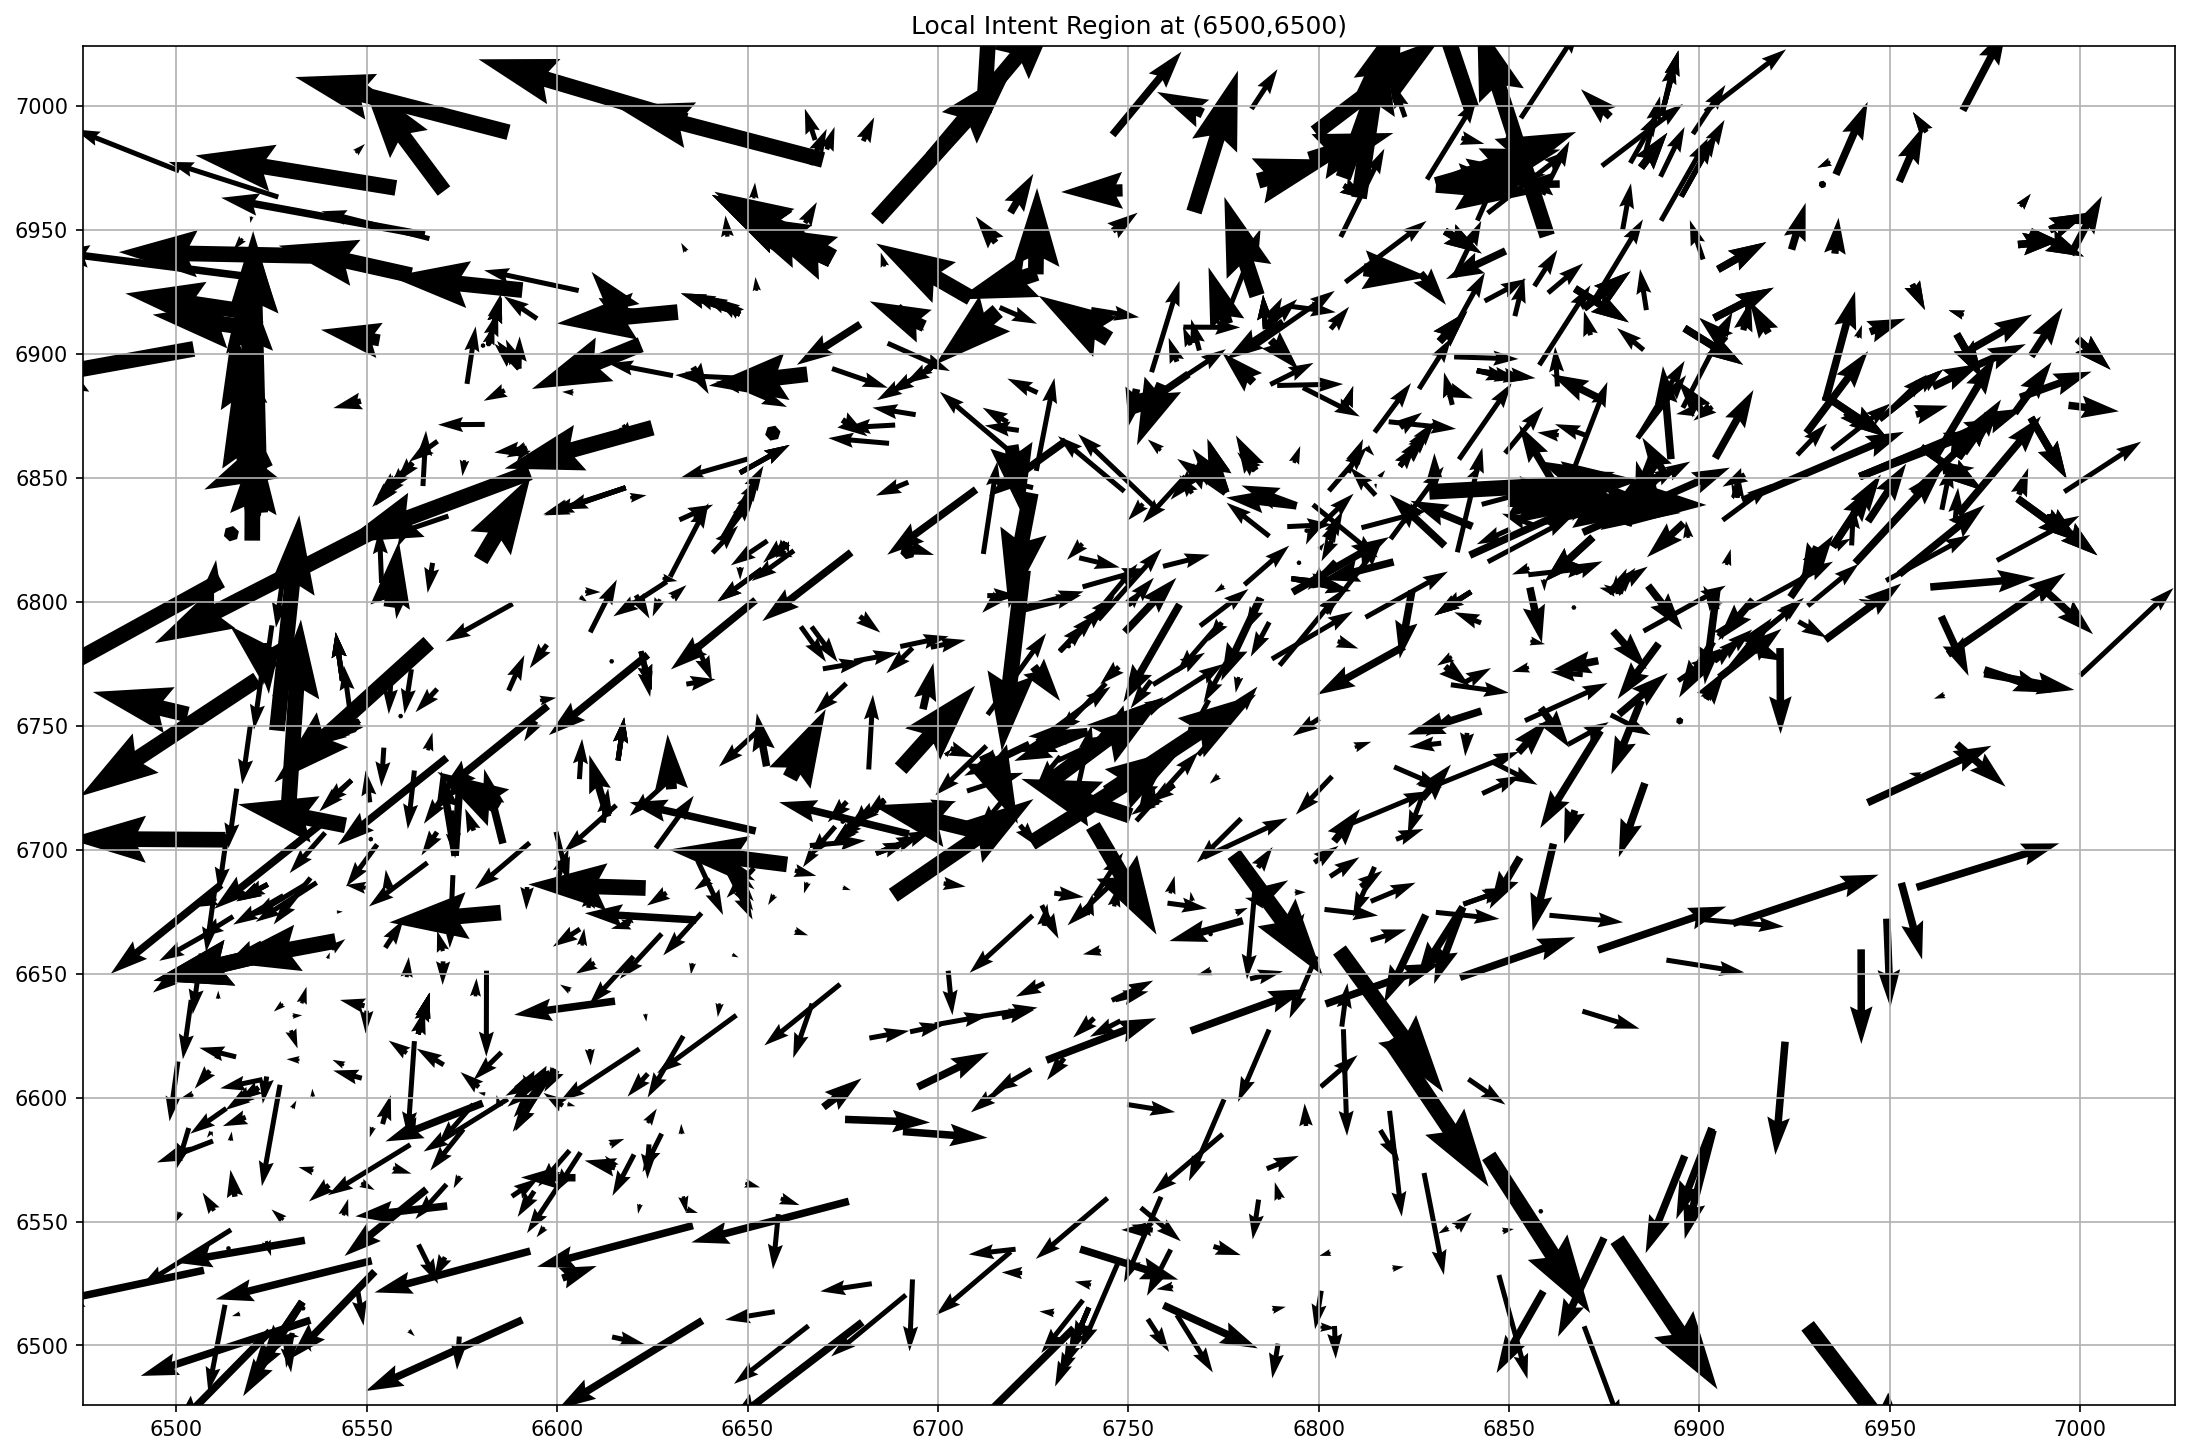

In [175]:
def _get_local_actions(row, x_off, y_off):
    # global_intent_region_size
    x = row.pos_x
    y = row.pos_z
    x_d = row.prev_pos_x
    y_d = row.prev_pos_z
    #print(x, y)
    if   x < x_off or x > x_off + global_intent_region_size * 1:
        return False
    elif y < y_off or y > y_off + global_intent_region_size * 1:
        return False
    elif x_d < x_off or x_d > x_off + global_intent_region_size * 1:
        return False
    elif y_d < y_off or y_d > y_off + global_intent_region_size * 1:
        return False
    else:
        return True

def _get_local_actions_only(x_off, y_off, champ_series):
    print(x_off, y_off)
    mask = champ_series.apply(lambda row:\
                              _get_local_actions(row, x_off, y_off), axis=1)
    champ_series = champ_series[mask]
    return champ_series
    
def _plot_map_local_scatter(champ_list, intervals, pos):
    print('champ name list:', champ_list)
    
    fig, ax = plt.subplots()
    
    intervals = intervals
    loc = plticker.MultipleLocator(base=intervals)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    
    plt.title(f"Local Intent Region at ({pos[0]*global_intent_region_size},{pos[1]*global_intent_region_size})")

    # remove (0, 0) rows from a champ

    cs = list(champ_list)
    lens = 0
    for c in cs:
        cur_champ = _get_local_actions_only(
            x_off=pos[0] * global_intent_region_size,
            y_off=pos[1] * global_intent_region_size,
            champ_series=champs_corrected[c],
        )
        lens += len(cur_champ)
        #STEP = (10 * 480) + (8*5)
        x = cur_champ.prev_pos_x
        y = cur_champ.prev_pos_z
        u = (cur_champ.prev_pos_x - cur_champ.pos_x)
        v = (cur_champ.prev_pos_z - cur_champ.pos_z)
        ax.quiver(x, y, u, v)
        #ax.scatter(cur_champ.pos_x, cur_champ.pos_z, s=10)
    print("total number of points in local region:", lens)
    
champ_names = champs_corrected.keys()
_plot_map_local_scatter(
    champ_names,
    local_intent_region_size,
    highest_activity_2d) # (28, 28)) #(28, 28))

# Spell Usage

## Spell Usage Temporal (When are spells used?)

dict_keys(['varus', 'jayce', 'hecarim', 'ornn', 'darius', 'lux', 'twistedfate', 'zilean', 'udyr', 'jinx'])


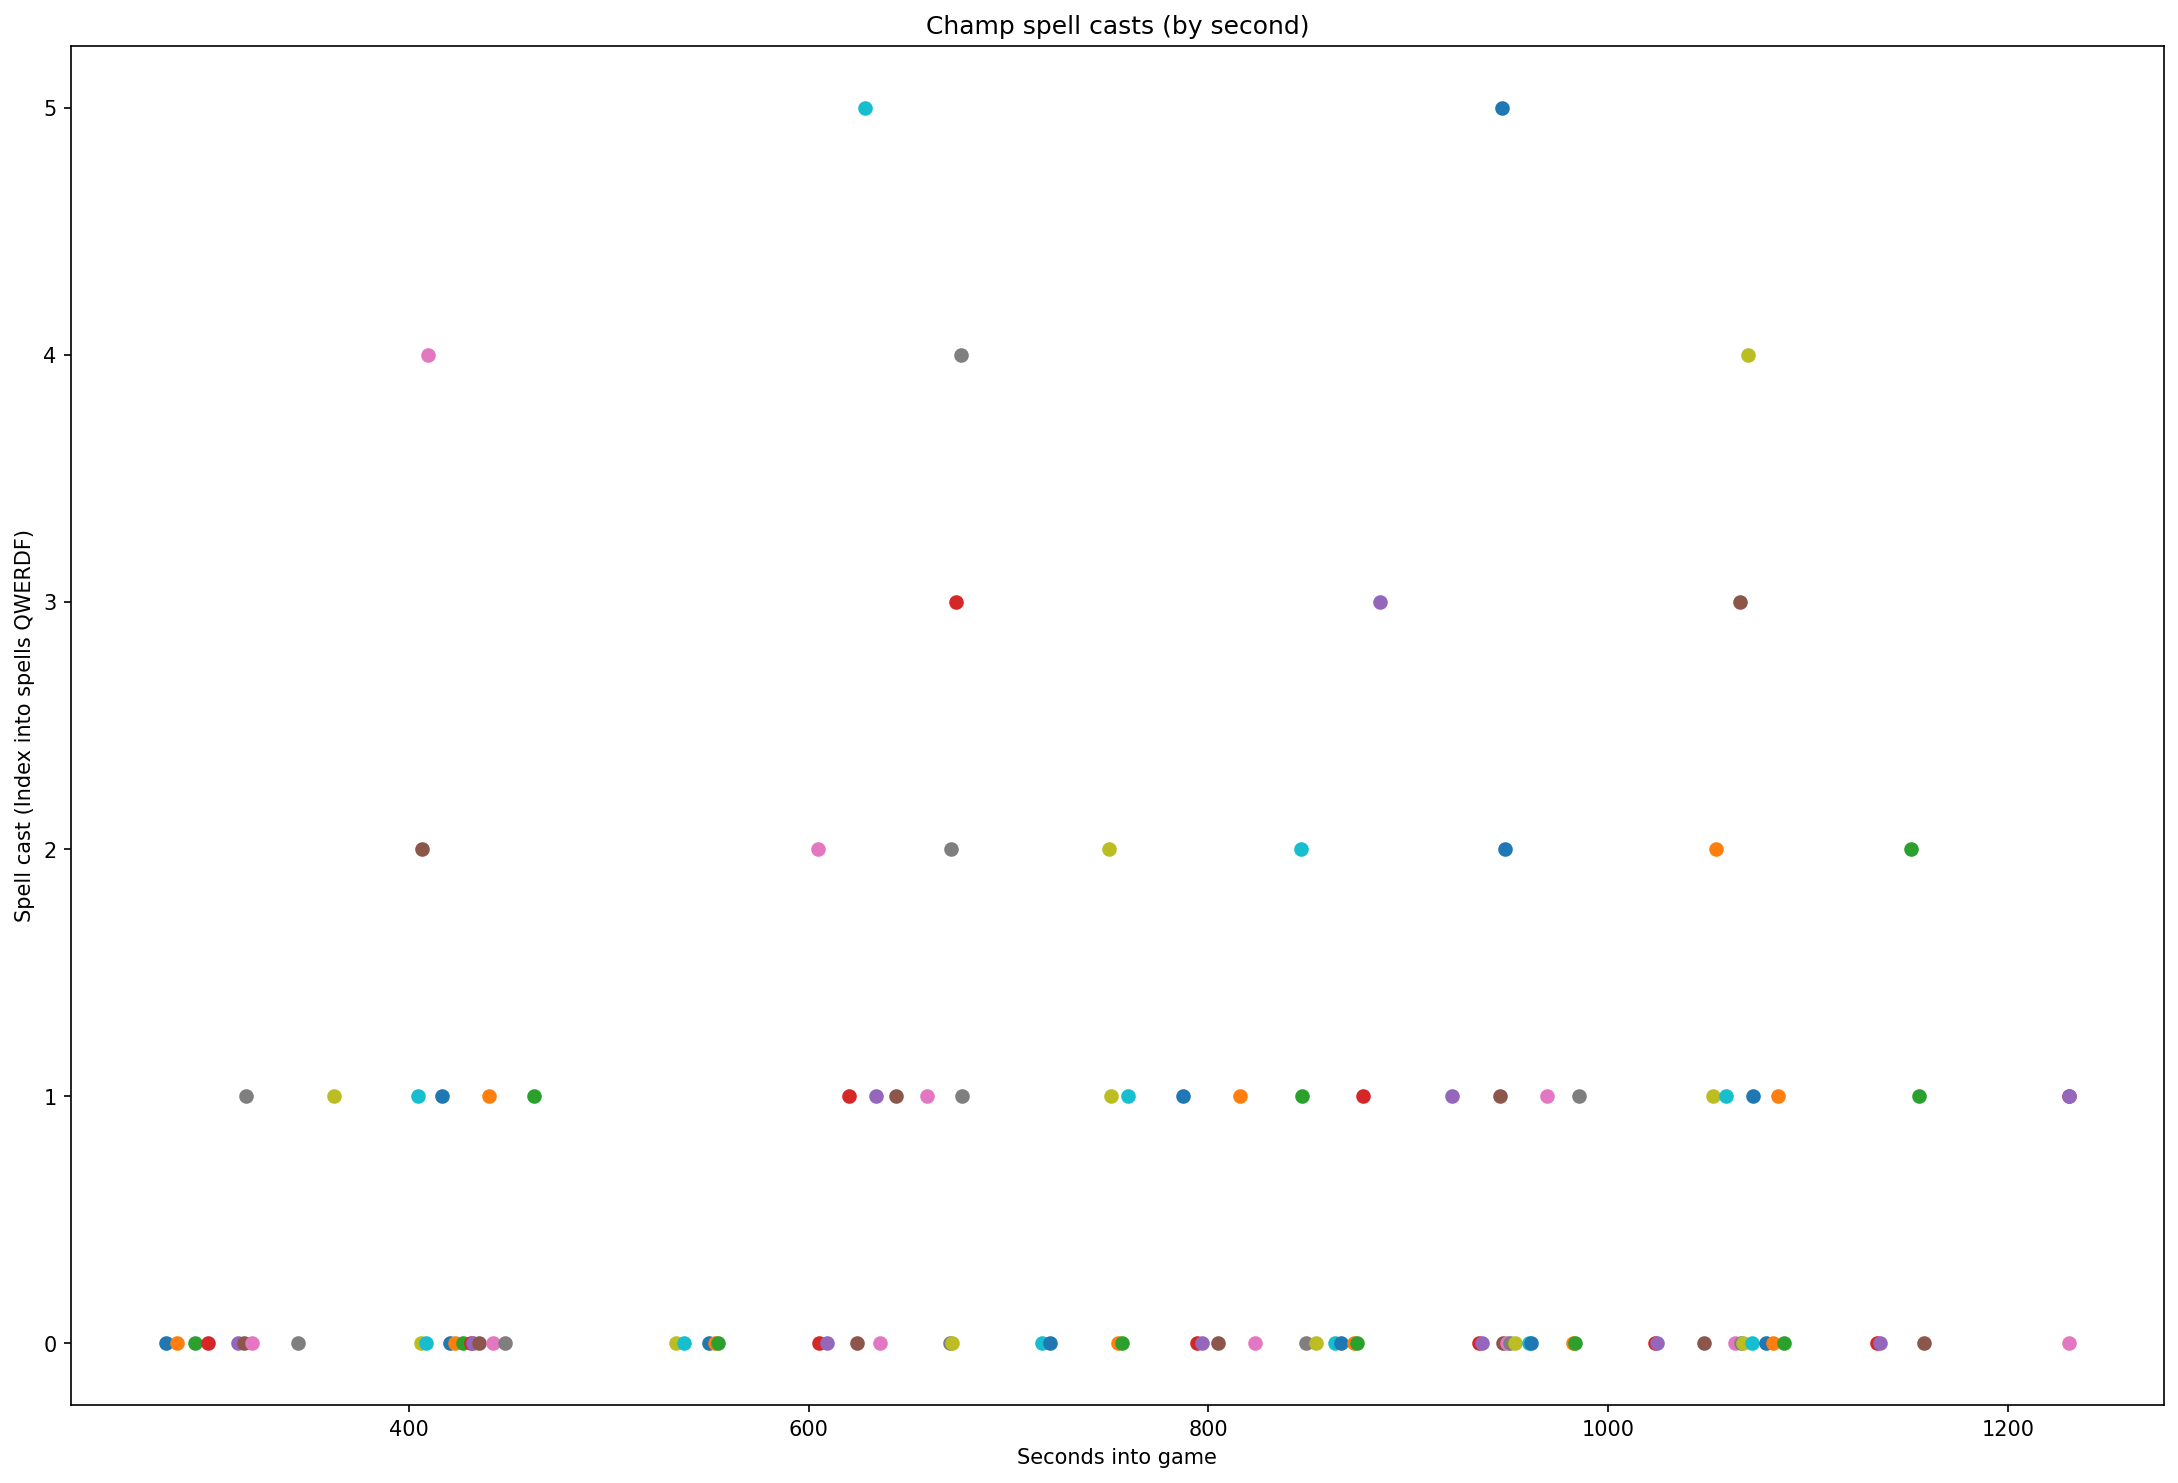

In [285]:
spells = ["q", "w", "e", "r", "d", "f"]
# spells = ["r"]
champ_list = champs_corrected.keys()
print(champ_list)
champ_list = ["jinx"]
fig, ax = plt.subplots()
plt.title("Champ spell casts (by second)")
ax.set_ylabel("Spell cast (Index into spells QWERDF)")
ax.set_xlabel("Seconds into game")
for c in champ_list:
    for i, spell in enumerate(spells):
        cur_champ = champs_corrected[c]
        cur_champ = cur_champ[cur_champ[f"{spell}_cast"] == True]
        cur_champ.apply(lambda row: ax.scatter(row["time"], i), axis=1)

## Spell Usage Spatial (Where are spells used?)

champ name list: dict_keys(['varus', 'jayce', 'hecarim', 'ornn', 'darius', 'lux', 'twistedfate', 'zilean', 'udyr', 'jinx'])
twistedfate spell casts: 292


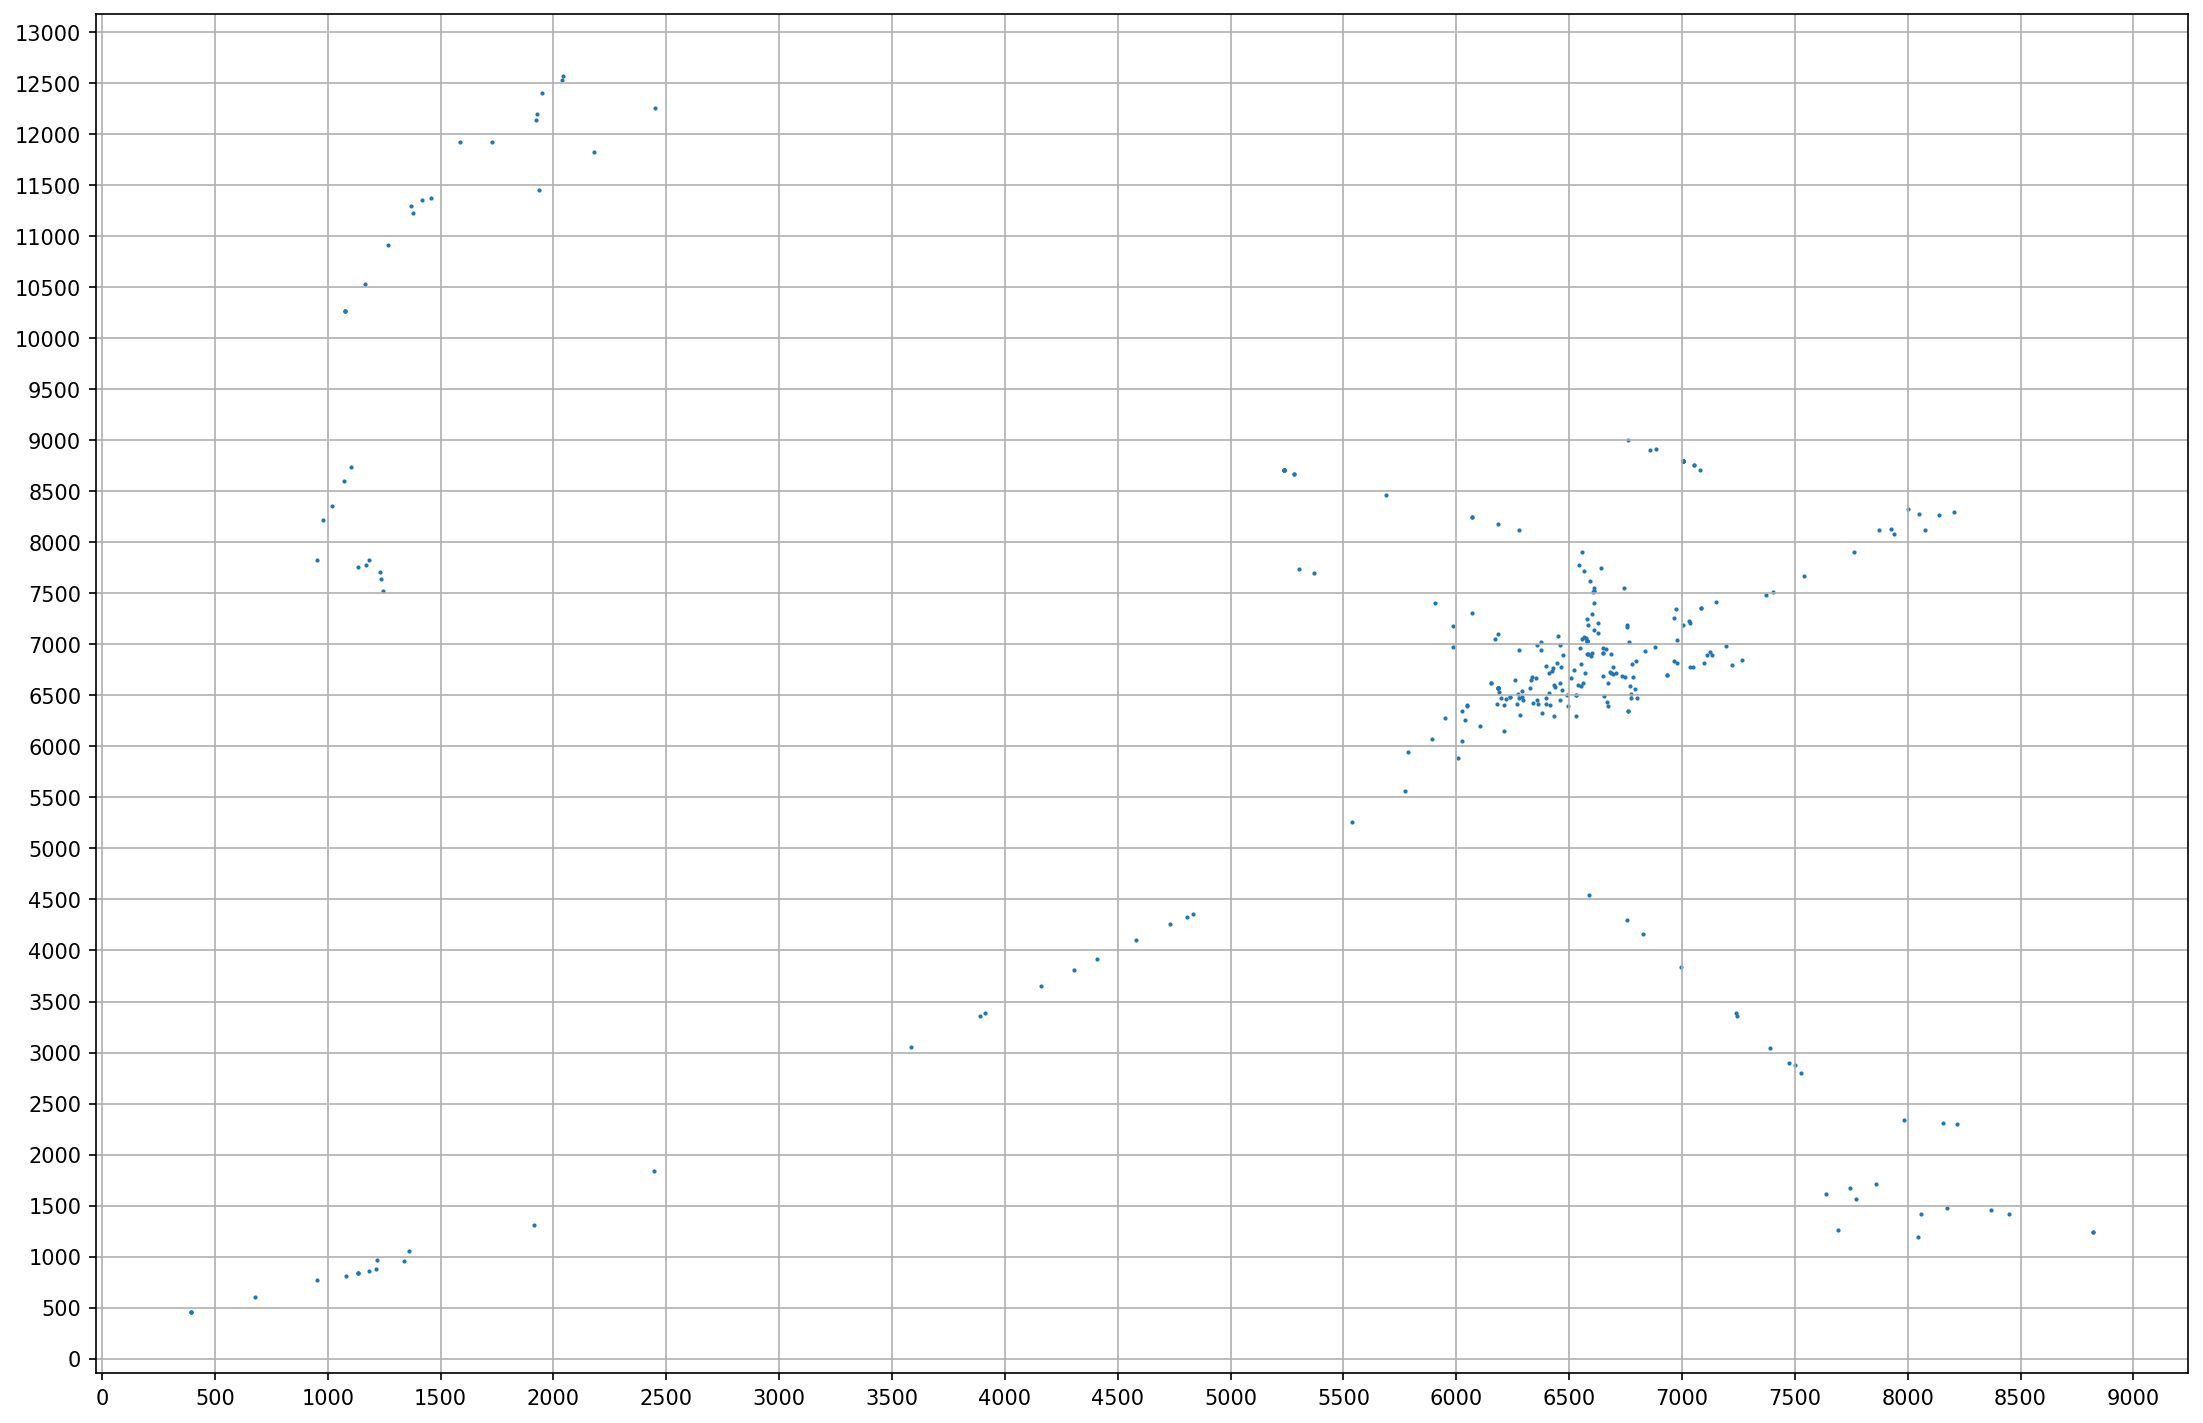

In [290]:
def plot_map_global_spell_scatter(champ_list, intervals):
    #champ_names_for_game = champs_corrected.keys()
    print('champ name list:', champ_list)
    
    fig, ax = plt.subplots()
    
    intervals = intervals
    loc = plticker.MultipleLocator(base=intervals)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    
    """
    for c in champs_corrected:
      plt.plot(champs_corrected[c].pos_x, champs_corrected[c].pos_z)
    """

    # remove (0, 0) rows from a champ

    cs = list(champ_list)
    #cs = ["kindred"]
    cs = ["twistedfate"]
    for c in cs:
        #new_c = champs_corrected[c][champs_corrected[c].pos_x > 0]
        #new_c = champs_corrected[c][champs_corrected[c].pos_y > 0]
        #plt.plot(new_c.pos_x, new_c.pos_z)
        # ax.plot(champs_corrected[c].pos_x, champs_corrected[c].pos_z)
        cur_champ = champs_corrected[c][
            (champs_corrected[c].q_cast == True) |
            (champs_corrected[c].w_cast == True) |
            (champs_corrected[c].e_cast == True) |
            (champs_corrected[c].r_cast == True) |
            (champs_corrected[c].d_cast == True) |
            (champs_corrected[c].f_cast == True)]
        print(f'{c} spell casts:', len(cur_champ))
        ax.scatter(cur_champ.pos_x, cur_champ.pos_z, s=1)
    
champ_names = champs_corrected.keys()
plot_map_global_spell_scatter(champ_names, global_intent_region_size)

## Auto Attack Analysis & Exploration